###### <p style="text-align: center; font-size: 24px;"><strong>Projet : Classifier automatiquement des biens de consommation</strong></p>

Mission : classification supervisée des images

Après avoir mené une étude de faisabilité sur la classification automatique des articles à partir de leurs images, nous avons évalué différentes méthodes d’extraction de caractéristiques visuelles. Les résultats obtenus en clustering non supervisé montrent des différences significatives de performance selon la méthode utilisée:

| Méthode           | Homogeneity | Completeness | V-measure | Adjusted Rand Index | Silhouette Score |
|:------------------|:------------|:-------------|:----------|:---------------------|:-----------------|
| SIFT + BoVW       | 0.039       | 0.055        | 0.046     | 0.018                | 0.036            |
| VGG16 (features) | 0.496   | 0.518        | 0.507     | 0.417                | 0.053            |
| ResNet50 (features)| 0.552      | 0.581        | 0.566     | 0.455               | 0.029            |
| EfficientNetB0 (features) | 0.633   | 0.645        | 0.639     | 0.585                | 0.067            |
| EfficientNetB0 (features) opti | 0.635   | 0.648        | 0.641     | 0.589                | 0.110            |

Ces résultats valident l’utilisation des représentations EfficientNetB0 pour la suite de notre projet.

Dans ce notebook, nous poursuivons la démarche en passant à la classification supervisée des articles à partir de leurs images, selon le plan suivant :

- Préparation des données : importation, prétraitement et découpage en ensembles d’entraînement, validation et test.

- Première approche : construction et évaluation d’un modèle d’apprentissage profond simple **(MLP minimal)** pour établir un point de référence.

- **Modèle CNN simple** (from scratch) : mise en œuvre d’un réseau de neurones convolutifs léger, entraîné depuis zéro, pour exploiter la structure spatiale des images.

- Modèles avancés : mise en œuvre d’un classifieur basé sur **EfficientNetB0**, puis amélioration progressive via la data augmentation et l’ajustement du dropout.

- Évaluation finale : analyse détaillée des performances du meilleur modèle sur le jeu de test.

- Conclusion et perspectives : synthèse des résultats et pistes d’amélioration.

Cette approche progressive permet d’établir des bases solides, de comparer différentes stratégies, et d’identifier les leviers les plus efficaces pour améliorer la classification automatique des biens de consommation à partir d’images.

# Importation des librairies

In [1]:
# Imports standards
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Fixer les seeds
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Importer TensorFlow
import tensorflow as tf
tf.random.set_seed(42) 

# Imports machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Imports Keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Imports pour le traitement des images
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Visualisation et suivi d'entraînement
from plot_keras_history import show_history, plot_history

# Importation et préparation des données
## Importation du dataframe

In [2]:
# Chargement du fichier
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

# Afficher les premières lignes
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

Ce fichier contient 1 050 produits issus du site e-commerce Flipkart, chacun avec 15 colonnes décrivant différentes caractéristiques du produit. Voici une description des colonnes :

| Colonne                   | Description                                                                 |
|:--------------------------|:----------------------------------------------------------------------------|
| `uniq_id`                 | Identifiant unique du produit                                               |
| `crawl_timestamp`         | Date et heure de récupération des données (scraping)                        |
| `product_url`             | Lien vers la page du produit sur Flipkart                                  |
| `product_name`            | Nom du produit                                                              |
| `product_category_tree`   | Catégorie hiérarchique du produit (ex. : Home >> Linge >> Draps...)         |
| `pid`                     | Identifiant produit interne (product ID)                                   |
| `retail_price`            | Prix de vente initial (avant réduction)                                    |
| `discounted_price`        | Prix après réduction                                                        |
| `image`                   | Nom du fichier image du produit                                             |
| `is_FK_Advantage_product` | Produit éligible au service "Flipkart Advantage" (similaire à Amazon Prime)|
| `description`             | Courte description ou points clés du produit                               |
| `product_rating`          | Note du produit (souvent "No rating available")                             |
| `overall_rating`          | Équivalent ou doublon de `product_rating`                                   |
| `brand`                   | Marque du produit (beaucoup de valeurs manquantes)                          |
| `product_specifications`  | Spécifications techniques sous forme de texte ou de structure JSON          |



La colonne product_category_tree contient la hiérarchie des catégories de produits dans le dataset. Chaque entrée de cette colonne est une chaîne de caractères qui représente la structure des catégories auxquelles un produit appartient. Les catégories sont séparées par l'opérateur >> et sont organisées selon un ordre hiérarchique allant de la catégorie la plus générale à la plus spécifique.

Par exemple :

Une entrée comme "Home >> Linge >> Draps" indique que le produit appartient à la catégorie "Draps", qui est un sous-ensemble de "Linge", lui-même une sous-catégorie de "Home".

Cette hiérarchisation permet de structurer les produits de manière logique, facilitant ainsi la recherche et la classification sur la plateforme de vente. Cependant, pour des analyses plus approfondies ou pour une utilisation automatisée, il peut être utile de démanteler cette hiérarchie en plusieurs niveaux, chacun représentant une catégorie spécifique du produit.

In [3]:
# On nettoie la chaîne pour retirer les crochets et guillemets
cleaned_categories = df['product_category_tree'].str.strip("[]").str.replace("'", "").str.replace('"', '')

# On compte le nombre de niveaux en comptant le nombre de séparateurs ">>" + 1
df['nb_niveaux'] = cleaned_categories.str.count('>>') + 1

# Afficher la distribution du nombre de niveaux
df['nb_niveaux'].value_counts().sort_index()

nb_niveaux
2      3
3    368
4    274
5    278
6     70
7     57
Name: count, dtype: int64

In [4]:
# Nettoyage de la colonne pour extraire la structure hiérarchique proprement
df['categorie_propre'] = df['product_category_tree'].str.extract(r'\["(.+?)"\]')

# On sépare les catégories hiérarchiques
categories_sep = df['categorie_propre'].str.split('>>', expand=True)

# On renomme les colonnes par niveau 
categories_sep.columns = [f"niveau_categorie_{i+1}" for i in range(categories_sep.shape[1])]

# On concatène au dataframe d'origine
df = pd.concat([df, categories_sep], axis=1)

# Suppression des colonnes temporaires
df.drop(columns=['nb_niveaux', 'categorie_propre'], inplace=True, errors='ignore')

In [5]:
df_image = df[['image', 'niveau_categorie_1']].copy()

## Importation des images

In [6]:
# Chemin racine vers les images
chemin_images = r"C:\Users\joan6\OneDrive\Bureau\Projets\Projet_6_Sole_Johanna\Dataset+projet+prétraitement+textes+images\Flipkart\Images"

# Ajouter une colonne avec le chemin complet
df_image['chemin_complet'] = df_image['image'].apply(lambda x: os.path.join(chemin_images, x))

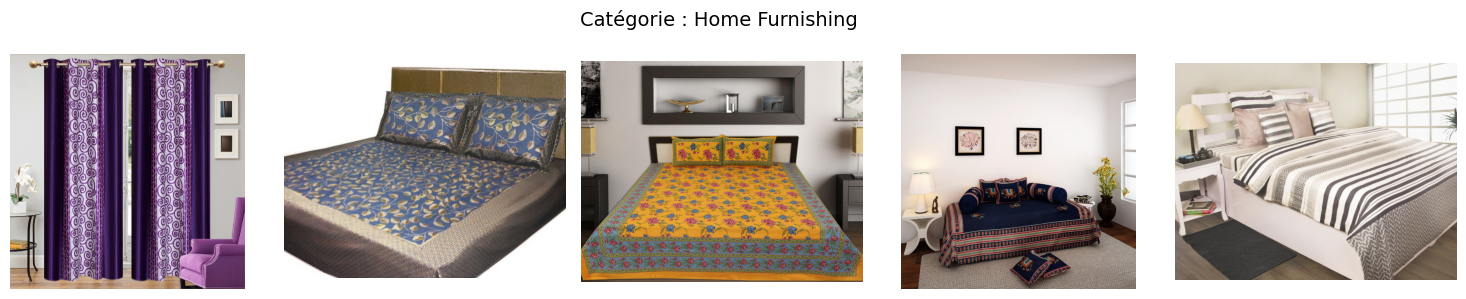

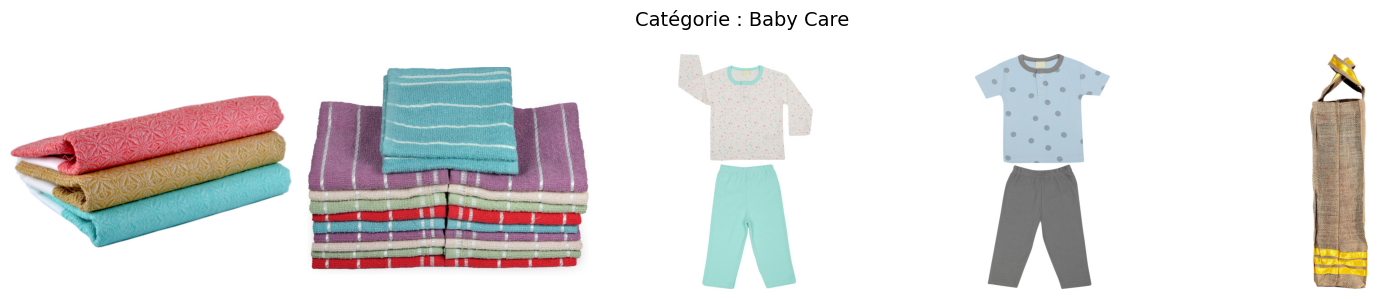

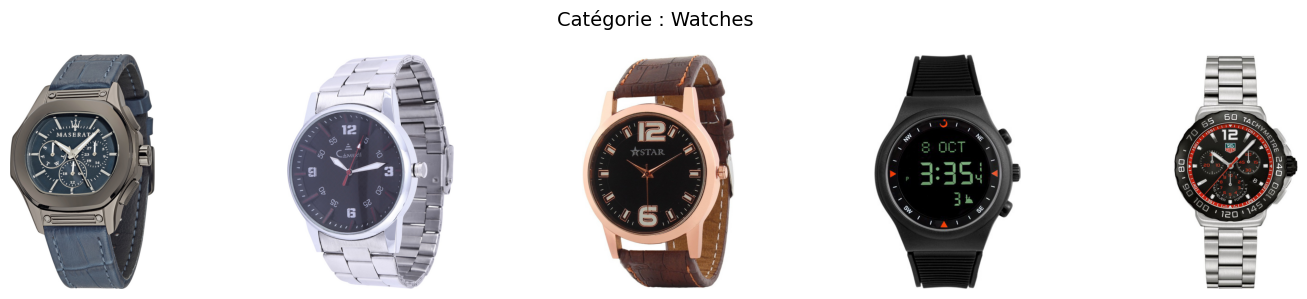

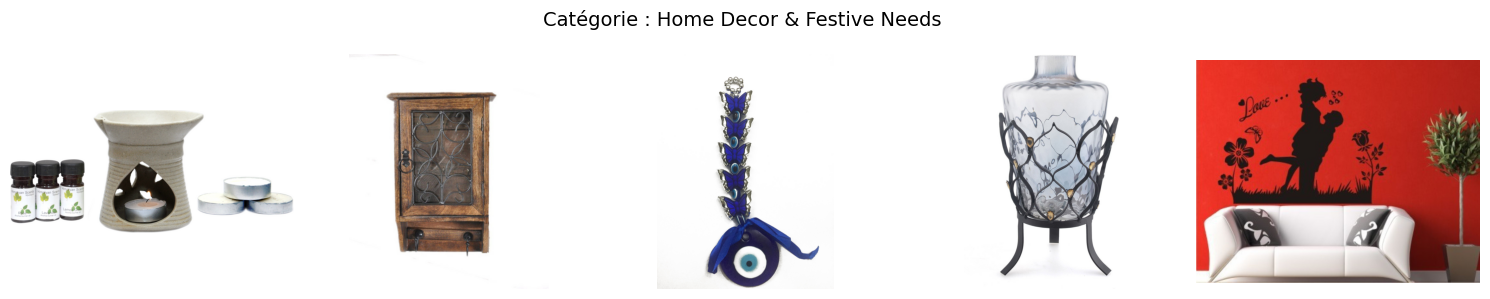

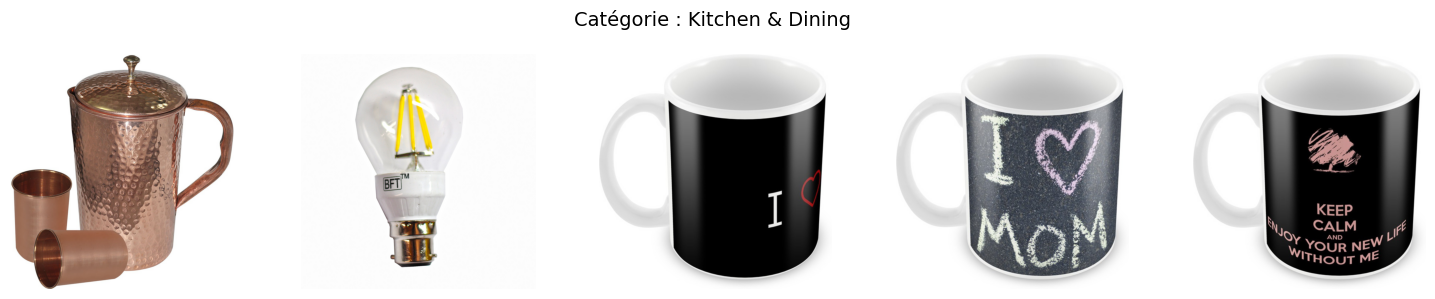

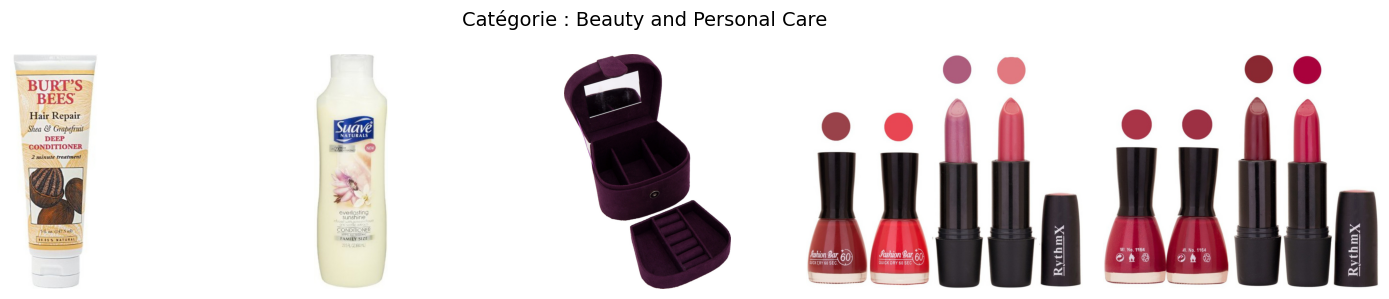

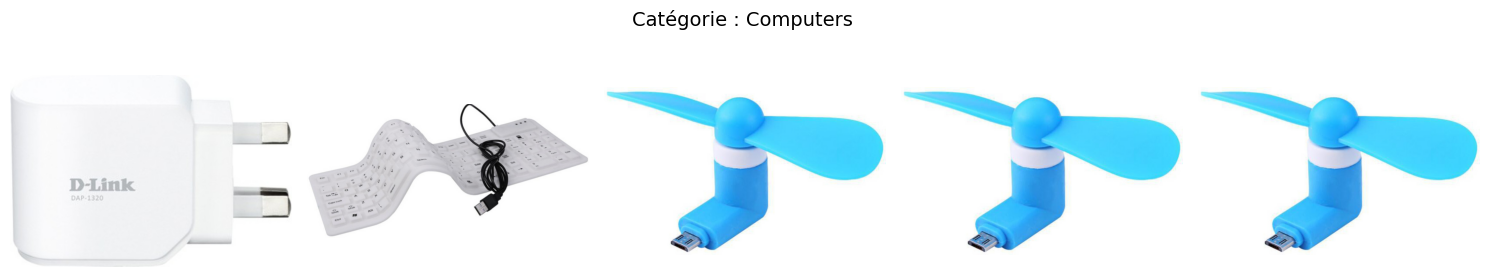

In [7]:
# Nombre d'images par catégorie
nb_images = 5

# Parcourir les catégories 
for categorie in df_image['niveau_categorie_1'].unique():
    # Filtrer les lignes correspondant à la catégorie
    df_cat = df_image[df_image['niveau_categorie_1'] == categorie].head(nb_images)
    
    # Créer une ligne de subplots
    fig, axes = plt.subplots(1, nb_images, figsize=(15, 3))
    fig.suptitle(f"Catégorie : {categorie}", fontsize=14)

    for i, (index, row) in enumerate(df_cat.iterrows()):
        try:
            image = Image.open(row['chemin_complet'])
            axes[i].imshow(image)
            axes[i].axis('off')
        except:
            axes[i].axis('off')
            axes[i].set_title("Image manquante", fontsize=8)

    plt.tight_layout()
    plt.show()

# Division du jeu de données en ensembles d’entraînement, de validation et de test

Afin d’évaluer de manière rigoureuse la performance du modèle de classification d’images, il est essentiel de séparer les données en trois ensembles distincts :
- un ensemble d’entraînement, utilisé pour l’apprentissage du modèle,
- un ensemble de validation, qui permet de suivre la performance du modèle pendant l’entraînement et d’ajuster les hyperparamètres,
- et un ensemble de test, réservé à l’évaluation finale.

Cette division garantit que les performances mesurées reflètent la capacité du modèle à généraliser sur des données nouvelles, jamais vues pendant l’entraînement, et évite tout risque de surapprentissage ou de biais d’évaluation.<br>
La division doit être réalisée en respectant la proportion des catégories (stratification) afin d’assurer un apprentissage et une évaluation équilibrés et représentatifs.

In [8]:
df_efficient = df_image[['image', 'niveau_categorie_1','chemin_complet']].copy()
df_efficient.head()

image niveau_categorie_1  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   Home Furnishing    
1  7b72c92c2f6c40268628ec5f14c6d590.jpg         Baby Care    
2  64d5d4a258243731dc7bbb1eef49ad74.jpg         Baby Care    
3  d4684dcdc759dd9cdf41504698d737d8.jpg   Home Furnishing    
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   Home Furnishing    

                                      chemin_complet  
0  C:\Users\joan6\OneDrive\Bureau\Projets\Projet_...  
1  C:\Users\joan6\OneDrive\Bureau\Projets\Projet_...  
2  C:\Users\joan6\OneDrive\Bureau\Projets\Projet_...  
3  C:\Users\joan6\OneDrive\Bureau\Projets\Projet_...  
4  C:\Users\joan6\OneDrive\Bureau\Projets\Projet_...

In [9]:
# Nombre d'images par catégorie
counts = df_efficient['niveau_categorie_1'].value_counts()

# Proportions (en %)
proportions = df_efficient['niveau_categorie_1'].value_counts(normalize=True) * 100

# Affichage
repartition = pd.DataFrame({
    'Effectif': counts,
    'Proportion (%)': proportions.round(2)
})

repartition

Effectif  Proportion (%)
niveau_categorie_1                                   
Home Furnishing                   150           14.29
Baby Care                         150           14.29
Watches                           150           14.29
Home Decor & Festive Needs        150           14.29
Kitchen & Dining                  150           14.29
Beauty and Personal Care          150           14.29
Computers                         150           14.29

In [10]:
# 1. Séparer X et y
X = df_efficient['chemin_complet']
y = df_efficient['niveau_categorie_1']

# 2. Split train (70%) / temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# 3. Split temp en val (15%) / test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Vérification des tailles
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

# Vérification de la répartition des classes dans chaque ensemble
print("\nRépartition train :")
print(y_train.value_counts())
print("\nRépartition validation :")
print(y_val.value_counts())
print("\nRépartition test :")
print(y_test.value_counts())

Train: 735
Validation: 157
Test: 158

Répartition train :
niveau_categorie_1
Home Decor & Festive Needs     105
Kitchen & Dining               105
Beauty and Personal Care       105
Computers                      105
Watches                        105
Home Furnishing                105
Baby Care                      105
Name: count, dtype: int64

Répartition validation :
niveau_categorie_1
Kitchen & Dining               23
Beauty and Personal Care       23
Baby Care                      23
Home Decor & Festive Needs     22
Computers                      22
Home Furnishing                22
Watches                        22
Name: count, dtype: int64

Répartition test :
niveau_categorie_1
Watches                        23
Home Furnishing                23
Computers                      23
Home Decor & Festive Needs     23
Kitchen & Dining               22
Beauty and Personal Care       22
Baby Care                      22
Name: count, dtype: int64


# Encodage de la cible

Il est essentiel de transformer les labels associés à chaque image dans un format compréhensible par le modèle de deep learning. Pour une tâche de classification multi-classes, les labels doivent généralement être encodés sous forme d’entiers ou, plus fréquemment, sous forme de vecteurs “one-hot” : chaque classe est représentée par un vecteur dont une seule case vaut 1 (celle correspondant à la classe), les autres étant à 0.

Concrètement, la préparation des labels se fait en deux étapes :

1. Encodage en entiers :<br>
On transforme d’abord les noms de catégories (“Baby Care”, “Home Furnishing”, etc.) en nombres entiers à l’aide d’un LabelEncoder. Cela permet au modèle de manipuler plus facilement les catégories, qui sont alors représentées par des chiffres (0, 1, 2…).

2. Encodage “one-hot” :<br>
On convertit ensuite ces entiers en vecteurs “one-hot” à l’aide de la fonction to_categorical de Keras. Chaque label devient alors un vecteur dont une seule case vaut 1 (celle correspondant à la classe de l’image), les autres étant à 0. Ce format est requis par la plupart des modèles de deep learning pour la classification multi-classes.

Cet encodage garantit que le modèle interprète correctement la cible à prédire et permet d’utiliser des fonctions de perte adaptées comme la “categorical cross-entropy”.

Dans cette étape, nous allons donc encoder les labels d’entraînement, de validation et de test afin de les rendre compatibles avec l’apprentissage supervisé du réseau de neurones.

In [25]:
# 1. Encodage en entiers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Créer un liste des labels
list_labels = list(le.classes_)

# 2. Encodage one-hot
y_train_oh = to_categorical(y_train_enc)
y_val_oh = to_categorical(y_val_enc)
y_test_oh = to_categorical(y_test_enc)

print("Shape des labels one-hot - train :", y_train_oh.shape)

Shape des labels one-hot - train : (735, 7)


# Construction d’un modèle d’apprentissage profond simple (MLP minimal)
Avant d’entraîner des architectures profondes avancées, il est important de commencer par un modèle de référence simple, basé sur l’apprentissage profond.
Nous choisissons ici un réseau de neurones dense (MLP) très basique, qui se contente de “mettre à plat” les images et d’apprendre à distinguer les classes sans utiliser de convolutions ni de transfert d’apprentissage.

Ce modèle sert de première baseline “apprenante” :
- Il permet de mesurer la performance minimale qu’un réseau de neurones profond, même très simple, peut atteindre sur notre jeu de données.

- Il offre un point de comparaison objectif pour évaluer l’apport des architectures plus complexes (CNN, modèles pré-entraînés…).

Dans cette section, nous allons donc construire, entraîner et évaluer ce modèle d’apprentissage profond simple avant de passer à des architectures plus sophistiquées.

## Préparation des images pour le MLP minimal
Avant d’entraîner notre modèle d’apprentissage profond simple, il est indispensable de préparer correctement les données d’entrée. Nous devons :

- Charger chaque image à partir de son chemin,

- Redimensionner les images à la taille attendue par le modèle,

- Normaliser les pixels (valeurs entre 0 et 1) pour faciliter l’apprentissage,

- Convertir les images en tableaux numpy, format requis par Keras.

Cette étape garantit que toutes les images sont homogènes et prêtes à être utilisées pour l’entraînement du MLP minimal.

In [64]:
IMG_SIZE = 224

def preprocess_images_list(list_paths, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Charge, redimensionne et normalise une liste d'images à partir de leurs chemins.

    Args:
        list_paths (list): Liste des chemins d'accès aux images.
        target_size (tuple): Taille cible pour le redimensionnement (hauteur, largeur).

    Returns:
        np.ndarray: Tableau numpy des images prétraitées, de forme (n_images, hauteur, largeur, 3).
    """
    images = []
    for path in list_paths:
        # Chargement et redimensionnement de l'image
        img = load_img(path, target_size=target_size)
        # Conversion en tableau numpy
        img = img_to_array(img)
        # Normalisation des pixels entre 0 et 1
        img = img / 255.0
        images.append(img)
    return np.array(images)

# Prétraitement des ensembles train, val et test
X_train_np = preprocess_images_list(X_train)
X_val_np   = preprocess_images_list(X_val)
X_test_np  = preprocess_images_list(X_test)

C:\Users\joan6\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## Construction et entraînement du MLP minimal
Après avoir préparé nos images et nos labels, nous allons maintenant construire un modèle d’apprentissage profond simple, appelé MLP minimal (Multi-Layer Perceptron).
Ce modèle, composé d’une couche de mise à plat suivie d’une couche dense avec une activation softmax, servira de première baseline “apprenante” pour notre tâche de classification d’images.


In [70]:
model_mlp = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Flatten(), # Mise à plat des images
    Dense(len(list_labels), activation='softmax') # Couche de sortie pour la classification
])

# Compilation du modèle
model_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement du modèle
history_mlp = model_mlp.fit(
    X_train_np, y_train_oh,
    validation_data=(X_val_np, y_val_oh),
    epochs=10,
    batch_size=32
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.1418 - loss: 87.3851 - val_accuracy: 0.1592 - val_loss: 65.1021
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2439 - loss: 45.0448 - val_accuracy: 0.2866 - val_loss: 17.3166
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3509 - loss: 14.1082 - val_accuracy: 0.3185 - val_loss: 18.2605
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3604 - loss: 14.7018 - val_accuracy: 0.3885 - val_loss: 15.6329
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4162 - loss: 11.9561 - val_accuracy: 0.3949 - val_loss: 14.3286
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4333 - loss: 10.5308 - val_accuracy: 0.3376 - val_loss: 15.0241
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4618 - loss: 10.4475 - val_accuracy: 0.3439 - val_loss: 17.5888
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4814 - loss: 9.6797 - val_accura

## Évaluation du MLP minimal 

Après l’entraînement du MLP minimal, il est important d’analyser ses performances de façon détaillée sur l’ensemble des jeux de données : entraînement, validation et test.
Nous allons donc mesurer l’exactitude (accuracy) mais aussi d’autres métriques de classification telles que la précision, le rappel, le score F1 et la matrice de confusion pour chaque jeu de données.

In [71]:
# 1. Accuracy et loss sur train, val, test
print("=== Évaluation globale ===")
for X, y_oh, name in zip(
    [X_train_np, X_val_np, X_test_np],
    [y_train_oh, y_val_oh, y_test_oh],
    ["Train", "Validation", "Test"]
):
    loss, acc = model_mlp.evaluate(X, y_oh, verbose=0)
    print(f"{name} - Loss : {loss:.4f} | Accuracy : {acc:.4f}")

# 2. Classification report et matrice de confusion sur validation uniquement
print("\n=== Détail sur le jeu de validation ===")
y_val_pred_proba = model_mlp.predict(X_val_np)
y_val_pred_enc = np.argmax(y_val_pred_proba, axis=1)

print("Classification report :")
print(classification_report(y_val_enc, y_val_pred_enc, target_names=list_labels))

print("Matrice de confusion :")
print(confusion_matrix(y_val_enc, y_val_pred_enc))

=== Évaluation globale ===
Train - Loss : 10.5530 | Accuracy : 0.4721
Validation - Loss : 16.5210 | Accuracy : 0.3567
Test - Loss : 17.7134 | Accuracy : 0.3734

=== Détail sur le jeu de validation ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Classification report :
                             precision    recall  f1-score   support

                 Baby Care        0.00      0.00      0.00        23
  Beauty and Personal Care        0.50      0.09      0.15        23
                 Computers        0.21      0.95      0.35        22
Home Decor & Festive Needs        0.00      0.00      0.00        22
           Home Furnishing        0.80      0.18      0.30        22
          Kitchen & Dining        0.40      0.43      0.42        23
                   Watches        0.79      0.86      0.83        22

                   accuracy                           0.36       157
                  macro avg       0.39      0.36      0.29       157
               weighted avg       0.38      0

C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


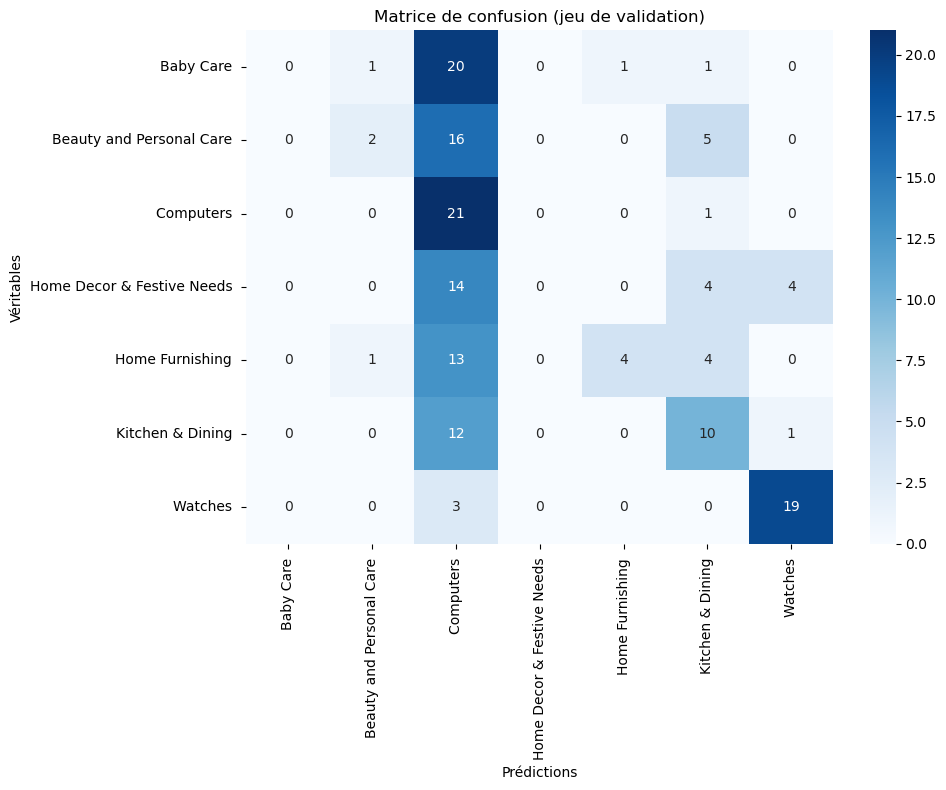

In [72]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_val_enc, y_val_pred_enc)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list_labels,
    yticklabels=list_labels
)
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de confusion (jeu de validation)')
plt.tight_layout()
plt.show()

Le MLP minimal obtient une accuracy de 47 % sur le jeu d’entraînement, mais cette performance chute à 36 % sur la validation et 37 % sur le test. Cette baisse importante entre l’entraînement et la validation/test confirme que le modèle généralise mal : il n’arrive pas à bien reconnaître les images qu’il n’a jamais vues.

L’analyse détaillée sur le jeu de validation montre un comportement très déséquilibré :

Seules les classes “Watches” et, dans une moindre mesure, “Computers” et “Kitchen & Dining” sont relativement bien reconnues (rappel élevé pour “Computers” et “Watches”, f1-score correct pour “Watches”).

Les autres classes, comme “Baby Care” et “Home Decor & Festive Needs”, ne sont quasiment jamais prédites correctement.

La matrice de confusion indique que le modèle a tendance à prédire massivement certaines classes (“Computers” notamment), au détriment des autres.

Globalement, ces résultats illustrent les limites d’un MLP minimal pour une tâche de classification d’images :
le modèle n’est pas capable d’extraire des caractéristiques visuelles suffisamment pertinentes pour bien séparer toutes les catégories.
Cela justifie le recours à des architectures plus avancées, telles que les réseaux de neurones convolutifs (CNN) ou des modèles pré-entraînés, pour améliorer significativement les performances.

# Construction d’un modèle CNN simple (à partir de zéro)
Après avoir établi une première base avec un perceptron multicouche (MLP), nous allons maintenant construire un réseau de neurones convolutif (CNN) simple que nous entraînons depuis zéro.
Contrairement au MLP, ce modèle exploitera la structure spatiale des images, ce qui lui permet de mieux capturer les motifs visuels importants, comme les contours, les textures ou les formes.
Ce CNN sera plus adapté que le MLP pour la classification d’images, tout en étant plus léger et plus facile à interpréter qu’un modèle avancé comme EfficientNetB0.

Nous allons commencer par préparer les images au bon format pour ce type de réseau.

## Préparation des images pour le CNN simple
Pour entraîner le modèle CNN simple, les images doivent être mises dans un format exploitable par un réseau de neurones convolutif :
- Redimensionnement à une taille uniforme de 224×224 pixels (comme pour les autres modèles),

- Conversion en tableaux de nombres (tensors),

- Normalisation des valeurs de pixels entre 0 et 1.

Comme nous avons déjà divisé les données (X_train, X_val, X_test), nous allons maintenant charger les images à partir des chemins contenus dans ces variables, appliquer les transformations nécessaires, et créer des tableaux X_train_cnn, X_val_cnn, X_test_cnn prêts à être utilisés par le modèle.

In [12]:
def preprocess_images(image_paths, target_size=(224, 224)):
    """
    Charge et prétraite une liste d'images à partir de leurs chemins d'accès.

    Paramètres :
    -----------
    image_paths : list or pandas.Series
        Liste des chemins d'accès vers les images à traiter.
    target_size : tuple (int, int), default=(224, 224)
        Dimensions (hauteur, largeur) auxquelles redimensionner chaque image.

    Retour :
    -------
    np.ndarray :
        Tableau numpy contenant les images transformées, normalisées entre 0 et 1
        et prêtes à être utilisées dans un modèle CNN (forme : [n_images, 224, 224, 3]).
    """
    images = []
    for path in tqdm(image_paths, desc="Préparation des images"):
        # Chargement et redimensionnement de l'image
        img = load_img(path, target_size=target_size)
        # Conversion en tableau numpy
        img_array = img_to_array(img)
        # Normalisation des pixels entre 0 et 1
        img_array = img_array / 255.0
        images.append(img_array)
    return np.array(images)

# Prétraitement des ensembles d'images
X_train_cnn = preprocess_images(X_train)
X_val_cnn = preprocess_images(X_val)
X_test_cnn = preprocess_images(X_test)

Préparation des images:  12%|██████▌                                                  | 85/735 [00:01<00:11, 58.34it/s]C:\Users\joan6\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Préparation des images: 100%|████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 48.34it/s]


## Mise en place des callbacks
Les callbacks sont des outils puissants qui permettent de suivre et d'ajuster l'entraînement du modèle en fonction de sa performance. Dans le cadre de ce projet, nous utiliserons plusieurs callbacks pour optimiser l'entraînement du modèle CNN.

- ModelCheckpoint : Ce callback permet de sauvegarder les poids du modèle chaque fois qu'il atteint une meilleure performance sur le jeu de validation (basée sur la perte). Cela nous permet de ne conserver que les meilleurs poids et de récupérer le modèle dans son état optimal.

- EarlyStopping : Ce callback arrête l'entraînement si la performance sur le jeu de validation ne s'améliore plus après un certain nombre d'epochs (patience). Cela permet de prévenir le surapprentissage et d'économiser des ressources de calcul lorsque le modèle n'apporte plus d'amélioration.

Ces deux callbacks sont essentiels pour garantir que l'entraînement soit efficace et pour éviter que le modèle ne sur-apprenne (overfitting) ou gaspille des ressources de calcul.

Les callbacks seront ensuite passés à la méthode fit() lors de l'entraînement du modèle pour surveiller et contrôler l'apprentissage.

In [15]:
# Chemin où seront sauvegardés les meilleurs poids du modèle
cnn_model_save_path = "./cnn_best_weights.h5"

# Callback pour sauvegarder les poids du modèle ayant la meilleure performance sur la validation
checkpoint_cnn = ModelCheckpoint(
    cnn_model_save_path,           # Fichier de sauvegarde
    monitor='val_loss',            # Critère surveillé (ici la perte sur la validation)
    verbose=1,                     # Affiche un message à chaque sauvegarde
    save_best_only=True,           # Sauvegarde uniquement si le modèle est meilleur
    mode='min'                     # On cherche à minimiser la val_loss
)

# Callback pour arrêter l'entraînement si la performance ne s'améliore plus
early_stop_cnn = EarlyStopping(
    monitor='val_loss',           # Critère surveillé
    mode='min',                    # On cherche à minimiser la val_loss
    verbose=1,                     # Affiche un message quand l'entraînement s'arrête
    patience=5                     # Nombre d'epochs sans amélioration avant arrêt
)

# Liste des callbacks à passer à model.fit()
callbacks_cnn = [checkpoint_cnn, early_stop_cnn]

## Construction de l’architecture du CNN
Dans cette section, nous allons définir l'architecture du modèle de réseau de neurones convolutifs (CNN) que nous allons entraîner pour la classification des images. Un CNN est particulièrement adapté à ce type de tâche, car il est conçu pour détecter et extraire les caractéristiques visuelles des images à travers plusieurs couches de convolution et de pooling.

L'architecture de notre modèle sera construite en utilisant les composants classiques d'un CNN, tels que :

- Couches de convolution : pour extraire des caractéristiques locales de l'image.

- Couches de pooling : pour réduire la taille des cartes de caractéristiques tout en conservant les informations essentielles.

- Couches entièrement connectées (dense) : pour effectuer la classification en fonction des caractéristiques extraites par les couches précédentes.

Nous allons créer un modèle relativement simple mais efficace, qui sera ensuite évalué sur les données d'entraînement, de validation et de test.

In [14]:
def build_cnn_model(input_shape, num_classes):
    """
    Fonction pour construire un modèle CNN simple avec Keras.
    
    Args:
        input_shape (tuple): La forme de l'entrée des images (hauteur, largeur, canaux).
        num_classes (int): Le nombre de classes à prédire.
    
    Returns:
        model (keras.Model): Le modèle CNN compilé.
    """
    model = models.Sequential()

    # Ajout d'une couche d'entrée explicite
    model.add(layers.Input(shape=input_shape)) 

    # Première couche de convolution
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Deuxième couche de convolution
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Troisième couche de convolution
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Aplatir les sorties de la dernière couche de convolution
    model.add(layers.Flatten())

    # Couches entièrement connectées (fully connected)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout pour éviter l'overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Sortie avec activation softmax pour la classification multi-classes

    return model

model_cnn = build_cnn_model(input_shape=(224, 224, 3), num_classes=7)
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,335 (49.36 MB)

 Trainable params: 12,939,335 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

L'entraînement du modèle est une étape clé dans le processus de deep learning, où le modèle apprend à partir des données d'entraînement et ajuste ses poids pour minimiser l'erreur de prédiction. Dans cette étape, le modèle CNN que nous avons construit sera entraîné avec les images d'entraînement et leurs labels correspondants.

L'objectif est d'ajuster les poids des couches du modèle en fonction des erreurs observées pendant l'entraînement, à l'aide d'une fonction de perte et d'un optimiseur. Comme il s'agit d'une tâche de classification multi-classes, nous utiliserons la fonction de perte "categorical cross-entropy", adaptée pour ce type de problème.

Les labels des images ont déjà été encodés en vecteurs one-hot, ce qui est requis pour la classification multi-classes. Nous allons maintenant configurer l'entraînement du modèle en définissant les paramètres d'entraînement, comme le nombre d'époques, la taille du batch, et l'optimiseur à utiliser.

Voici les étapes générales :

- Préparer les données d'entraînement et de validation : Les données d'entraînement (X_train_cnn, y_train_oh) et de validation (X_val_cnn, y_val_oh) doivent être prêtes.

- Choisir la fonction de perte, l'optimiseur et les métriques : Nous utiliserons la "categorical cross-entropy" pour la perte, l'optimiseur "Adam" pour une convergence rapide, et "accuracy" comme métrique.

- Lancer l'entraînement : Utilisation de la méthode fit() pour entraîner le modèle sur les données d'entraînement et valider sur les données de validation.

**Compilation du modèle :**

Avant de commencer l'entraînement, nous devons compiler le modèle en définissant l'optimiseur, la fonction de perte et les métriques à utiliser.

- Optimiseur : Nous choisissons l'optimiseur Adam car il est largement utilisé en deep learning pour sa capacité à ajuster efficacement les poids du modèle. Adam combine les avantages de deux autres optimisateurs, Adagrad et RMSprop, en adaptant les taux d'apprentissage pendant l'entraînement, ce qui accélère la convergence.

- Fonction de perte : Pour la classification multi-classes, nous utilisons la fonction de perte categorical cross-entropy. Elle mesure la différence entre les prédictions du modèle (les probabilités des classes) et les vraies étiquettes (sous forme de vecteurs one-hot). L'objectif est de minimiser cette différence au fur et à mesure de l'entraînement.

- Métriques : Nous choisissons accuracy comme métrique, car elle mesure le pourcentage de prédictions correctes, ce qui est un bon indicateur de la performance du modèle pour une tâche de classification.

Une fois le modèle compilé, nous pourrons l'entraîner en utilisant la méthode fit(), qui ajustera les poids du modèle à l'aide de l'optimiseur et de la fonction de perte définis.

In [17]:
# Compilons le modèle avec un optimiseur et une fonction de perte adaptés
model_cnn.compile(
    optimizer=Adam(),            # Utilisation de l'optimiseur Adam pour une convergence rapide
    loss='categorical_crossentropy',  # Fonction de perte pour la classification multi-classes
    metrics=['accuracy']         # Métriques d'évaluation, ici l'exactitude (accuracy)
)

# Entraînement du modèle avec les données d'entraînement et de validation
history4 = model_cnn.fit(
    X_train_cnn,           # Images d'entraînement prétraitées
    y_train_oh,            # Labels d'entraînement en one-hot
    epochs=50,             # Nombre maximal d'epochs (itérations sur tout le jeu de données)
    batch_size=64,         # Nombre d'images par lot (batch) lors de l'entraînement
    validation_data=(X_val_cnn, y_val_oh),   # Images et labels de validation
    callbacks=callbacks_cnn, # Liste des callbacks (sauvegarde des meilleurs poids, early stopping)
    verbose=1              # Affiche la progression de l'entraînement à chaque epoch
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.1674 - loss: 2.9926
Epoch 1: val_loss improved from inf to 1.88809, saving model to ./cnn_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1680 - loss: 2.9562 - val_accuracy: 0.2548 - val_loss: 1.8881
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.1975 - loss: 1.8890
Epoch 2: val_loss improved from 1.88809 to 1.74510, saving model to ./cnn_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1998 - loss: 1.8878 - val_accuracy: 0.3631 - val_loss: 1.7451
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.3759 - loss: 1.6792
Epoch 3: val_loss improved from 1.74510 to 1.56389, saving model to ./cnn_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3767 - loss: 1.6768 - val_accuracy: 0.4395 - val_loss: 1.5639
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.4539 - loss: 1.4840
Epoch 4: val_loss improved from 1.56389 to 1.49662, saving model to ./cnn_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4538 - loss: 1.4814 - val_accuracy: 0.4841 - val_loss: 1.4966
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5010 - loss: 1.3119
Epoch 5: val_loss improved from 1.49662 to 1.44776, saving model to ./cnn_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5026 - loss: 1.3085 - val_accuracy: 0.4777 - val_loss: 1.4478
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.5478 - loss: 1.2025
Epoch 6: val_loss did not improve from 1.44776
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5491 - loss: 1.1980 - val_accuracy: 0.4904 - val_loss: 1.5840
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.5828 - loss: 1.1696
Epoch 7: val_loss did not improve from 1.44776
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5851 - loss: 1.1626 - val_accuracy: 0.4650 - val_loss: 1.5787
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.6760 - loss: 0.9326
Epoch 8: val_loss did not improve from 1.44776
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6784 - loss: 0.9254 - val_accuracy: 0.5096 - val_loss: 1.5720
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.7216 - loss: 0.7822
Epoch 9: val_loss did not improve from 1.44776
12/12 ━

## Évaluation du modèle

In [18]:
# Évaluation avec les poids du dernier epoch (avant de recharger les meilleurs poids)
loss, accuracy = model_cnn.evaluate(X_train_cnn, y_train_oh, verbose=True)
print("Précision sur l'entraînement (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (dernier epoch) : {:.4f}".format(loss))
print()

loss, accuracy = model_cnn.evaluate(X_val_cnn, y_val_oh, verbose=True)
print("Précision sur la validation (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur la validation (dernier epoch) : {:.4f}".format(loss))
print()

# Chargement des meilleurs poids sauvegardés par ModelCheckpoint
model_cnn.load_weights(cnn_model_save_path)

# Évaluation sur l'ensemble d'entraînement avec les meilleurs poids
loss, accuracy = model_cnn.evaluate(X_train_cnn, y_train_oh, verbose=False)
print("Précision sur l'entraînement (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de validation avec les meilleurs poids
loss, accuracy = model_cnn.evaluate(X_val_cnn, y_val_oh, verbose=False)
print("Précision sur la validation (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur la validation (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de test avec les meilleurs poids
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test_oh, verbose=False)
print("Précision sur le test (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur le test (meilleurs poids) : {:.4f}".format(loss))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8857 - loss: 0.3732
Précision sur l'entraînement (dernier epoch) : 0.8844
Loss sur l'entraînement (dernier epoch) : 0.3728

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4639 - loss: 1.7131
Précision sur la validation (dernier epoch) : 0.4841
Loss sur la validation (dernier epoch) : 1.6852

Précision sur l'entraînement (meilleurs poids) : 0.6571
Loss sur l'entraînement (meilleurs poids) : 1.0377

Précision sur la validation (meilleurs poids) : 0.4777
Loss sur la validation (meilleurs poids) : 1.4478

Précision sur le test (meilleurs poids) : 0.5063
Loss sur le test (meilleurs poids) : 1.4236


|                         | Entraînement (meilleurs poids) | Validation (meilleurs poids) | Test (meilleurs poids) |
|:------------------------|:-------------------------------:|:----------------------------:|:-----------------------:|
| **Précision (MLP minimal)** | 0.4721                         | 0.3567                       | 0.3734                  |
| **Précision (CNN)**   | 0.6571                         | 0.4777                       | 0.5063                  |

L'analyse des performances montre une nette amélioration avec le modèle CNN par rapport au MLP minimal. Le CNN atteint une précision de 65,71 % sur l'entraînement et de 47,77 % sur la validation, contre 47,21 % et 35,67 % pour le MLP minimal, respectivement. <br>
Sur l'ensemble de test, le CNN obtient une précision de 50,63 %, tandis que le MLP minimal reste à 37,34 %. Ces résultats indiquent que le CNN est globalement plus performant, avec une meilleure généralisation aux données de validation et de test, suggérant qu'il capture mieux les caractéristiques complexes des données.

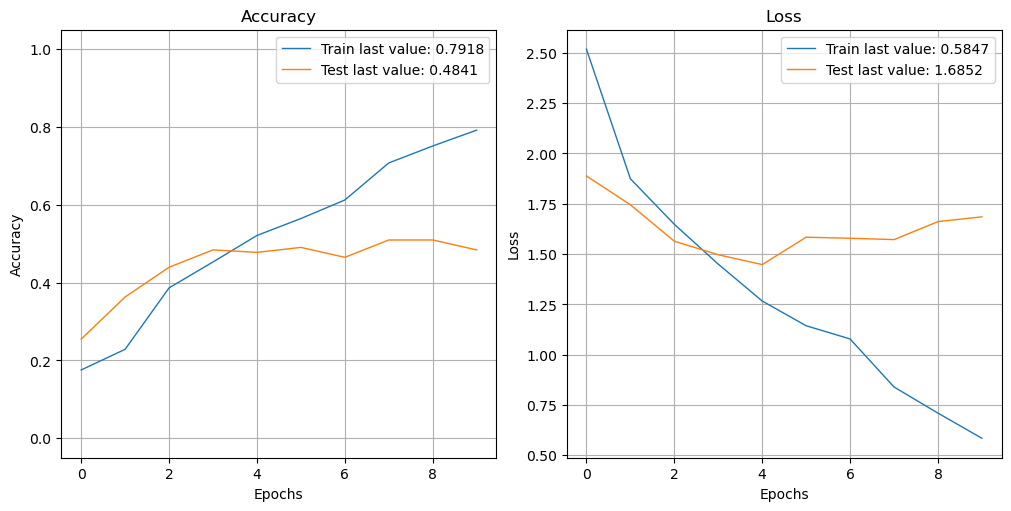

In [19]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [21]:
# y_val_oh : labels de validation au format one-hot
y_val_num = np.argmax(y_val_oh, axis=1)  # Vraies classes (entiers)
y_val_pred = np.argmax(model_cnn.predict(X_val_cnn), axis=1)  # Prédictions du modèle
print("Vraies classes :", y_val_num)
print("Prédictions :", y_val_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Vraies classes : [3 2 5 4 2 4 1 5 4 0 0 5 3 5 1 3 4 5 1 6 1 1 0 3 3 4 4 5 4 0 3 2 3 5 1 3 0
 0 6 5 4 6 4 6 6 6 0 3 3 4 4 4 2 1 2 6 5 6 3 3 6 6 6 4 0 3 2 4 5 5 3 3 6 2
 6 3 3 0 2 3 5 4 2 2 5 5 0 3 3 0 0 0 2 0 1 1 2 0 2 0 5 5 2 6 1 1 6 1 6 1 0
 1 5 6 3 0 4 1 2 0 3 2 1 5 6 6 4 5 2 2 1 0 5 2 5 6 4 6 4 1 1 5 4 0 5 1 0 2
 1 0 6 2 2 4 1 4 1]
Prédictions : [3 1 5 3 2 4 1 0 3 2 3 4 3 6 3 3 4 3 2 6 3 1 3 3 3 1 4 5 4 2 3 3 3 3 1 3 4
 4 6 3 4 6 2 2 6 6 4 2 3 3 4 1 2 3 4 6 2 6 3 2 6 0 6 3 2 1 2 3 2 2 3 3 6 2
 6 4 4 2 3 3 2 4 2 2 3 2 3 3 5 4 0 0 2 0 3 2 2 4 2 2 3 5 2 6 3 1 6 4 6 3 3
 2 0 2 4 2 2 3 2 3 3 2 1 2 6 3 2 5 5 2 3 2 2 0 6 6 4 6 4 1 1 6 2 0 0 3 3 2
 1 4 0 2 2 3 1 3 1]


In [22]:
# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :\n", conf_mat)

Matrice de confusion :
 [[ 4  0  7  6  6  0  0]
 [ 0 10  3  9  1  0  0]
 [ 1  1 16  2  1  1  0]
 [ 0  1  2 15  3  1  0]
 [ 0  2  4  7  9  0  0]
 [ 3  0  7  5  1  4  3]
 [ 2  0  2  1  0  0 17]]


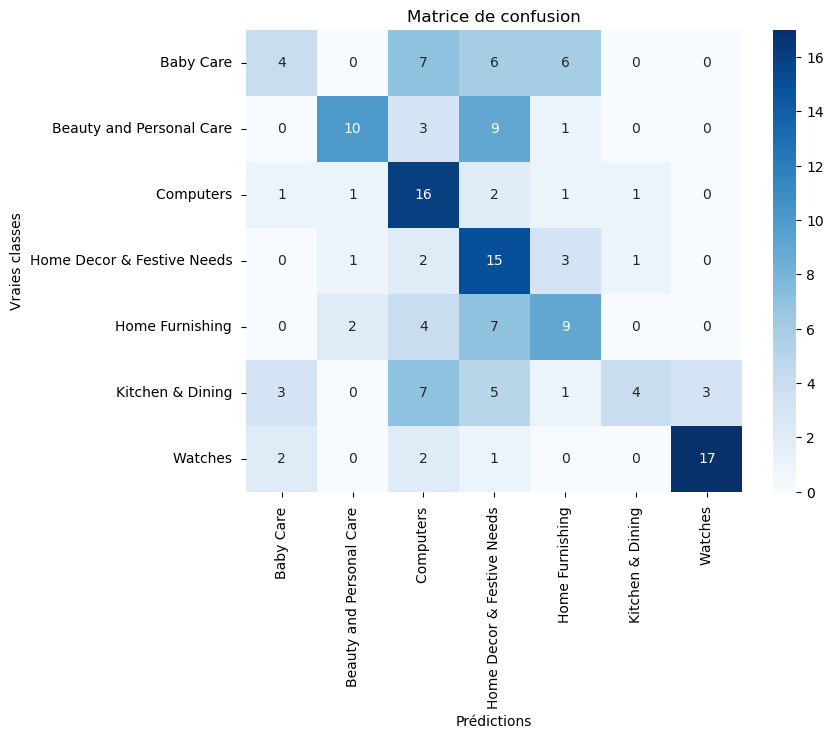

In [26]:
# Création d'un DataFrame pour la matrice de confusion
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=list_labels)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

Cette matrice de confusion montre que les catégories Computers, Home Decor & Festive Needs, et Watches sont les mieux reconnues, avec respectivement 16, 15 et 17 bonnes prédictions. En revanche, les catégories comme Baby Care (4/23 correctes) et Kitchen & Dining (4/23 correctes) sont souvent confondues avec d’autres, notamment avec Computers et Home Decor, ce qui suggère un chevauchement visuel ou des limites du modèle à bien les distinguer. Le modèle a donc de bonnes performances sur certaines classes, mais reste confus sur les catégories proches.

In [28]:
# Rapport de classification
print(metrics.classification_report(y_val_num, y_val_pred, target_names=list_labels))

                             precision    recall  f1-score   support

                 Baby Care        0.40      0.17      0.24        23
  Beauty and Personal Care        0.71      0.43      0.54        23
                 Computers        0.39      0.73      0.51        22
Home Decor & Festive Needs        0.33      0.68      0.45        22
           Home Furnishing        0.43      0.41      0.42        22
          Kitchen & Dining        0.67      0.17      0.28        23
                   Watches        0.85      0.77      0.81        22

                   accuracy                           0.48       157
                  macro avg       0.54      0.48      0.46       157
               weighted avg       0.54      0.48      0.46       157



Le rapport de classification confirme les tendances observées dans la matrice de confusion : Watches, Computers, et Home Decor & Festive Needs ont de bons rappels (respectivement 0.77, 0.73, 0.68), indiquant que le modèle identifie souvent correctement ces classes. En revanche, Baby Care et Kitchen & Dining ont des scores très faibles, notamment en recall (0.17), ce qui montre qu'elles sont mal détectées. Le modèle semble donc performant sur certaines classes bien distinctes, mais en difficulté sur celles qui se ressemblent visuellement.

Cette limite du CNN simple souligne l’intérêt de passer à un modèle plus puissant comme EfficientNetB0, capable de mieux capter les différences fines entre catégories visuellement proches grâce à une extraction de caractéristiques plus riche et optimisée.

# Construction du modèle de classification avec EfficientNetB0

Dans cette étape, nous allons construire un modèle de classification supervisée complet, intégrant à la fois l’extraction des caractéristiques visuelles et la prédiction des catégories. Nous utiliserons EfficientNetB0 pré-entraîné comme base (backbone) pour extraire automatiquement des représentations visuelles pertinentes à partir des images, en retirant sa couche finale de classification. Ensuite, nous ajouterons des couches denses spécifiques à notre tâche pour apprendre à classer les images selon nos propres catégories.

Cette approche “end-to-end” permet d’entraîner efficacement le modèle tout en bénéficiant de la puissance du transfer learning, et facilite l’intégration de techniques comme la data augmentation pour améliorer la robustesse du modèle

## Préparation des images pour l’entraînement, la validation et le test

Après avoir séparé notre jeu de données en ensembles d’entraînement, de validation et de test, il est essentiel de préparer correctement les images et les labels pour chaque sous-ensemble.<br>
Cette préparation consiste à charger les images depuis leurs chemins respectifs, à les redimensionner et à appliquer les prétraitements spécifiques requis par le modèle pré-entraîné EfficientNetB0 (redimensionnement, conversion RGB).

Le détail du prétraitement (redimensionnement, conversion RGB) a été présenté dans le notebook précédent. Nous appliquons ici la même procédure, afin de garantir la compatibilité des images avec le modèle utilisé.

In [73]:
def preprocess_efficientnetb0(image_path):
    """
    Prétraite une image pour EfficientNetB0 :
    - Charge l'image depuis le chemin,
    - Convertit en RGB,
    - Redimensionne à 224x224 pixels,
    - Transforme en tableau NumPy float32,
    Retourne un array (224, 224, 3) prêt à être passé dans le modèle.
    """
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224), Image.BILINEAR)
        img_np = np.array(image).astype(np.float32)
        if img_np.shape != (224, 224, 3):
            raise ValueError("L'image n'a pas le format attendu (224, 224, 3).")
        img_np = np.expand_dims(img_np, axis=0)
        return img_np[0]
    except Exception as e:
        print(f"Erreur lors du traitement de {image_path} : {e}")
        return None

In [74]:
def preprocess_images_list(image_paths):
    """
    Applique le prétraitement EfficientNetB0 à une liste de chemins d'images.

    Paramètres
    ----------
    image_paths : list ou pandas.Series
        Liste ou série contenant les chemins complets des images à prétraiter.

    Retourne
    -------
    np.ndarray
        Tableau numpy de forme (nb_images, 224, 224, 3) contenant toutes les images prétraitées.
        Les images corrompues ou non lisibles sont ignorées.
    """
    images = []  # Liste pour stocker les images prétraitées
    for path in tqdm(image_paths, desc="Prétraitement des images"):
        img = preprocess_efficientnetb0(path)  # Applique le prétraitement à chaque image
        if img is not None:  # Vérifie que l'image a bien été chargée et prétraitée
            images.append(img)  # Ajoute l'image prétraitée à la liste
    return np.array(images)  # Convertit la liste en array numpy pour le deep learning

In [75]:
# Application à chaque ensemble
X_train_np = preprocess_images_list(X_train)
X_val_np = preprocess_images_list(X_val)
X_test_np = preprocess_images_list(X_test)

# Vérification des shapes
print("Train:", X_train_np.shape)
print("Validation:", X_val_np.shape)
print("Test:", X_test_np.shape)

Prétraitement des images:  12%|██████▌                                                | 88/735 [00:03<00:17, 36.16it/s]C:\Users\joan6\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Prétraitement des images: 100%|██████████████████████████████████████████████████████| 158/158 [00:05<00:00, 30.80it/s]

Train: (735, 224, 224, 3)
Validation: (157, 224, 224, 3)
Test: (158, 224, 224, 3)


## Définition de l’architecture du modèle

Avant de construire le modèle dans le code, il faut décider comment il sera fait.
- On utilise EfficientNetB0 :
C’est un modèle déjà entraîné sur plus d’un million d’images de toutes sortes (animaux, objets, etc.).
Il a appris à bien reconnaître plein de choses différentes, donc il sait déjà “voir” ce qui est important dans une image.

- On garde ses connaissances :
On bloque (on “gèle”) ses paramètres pour ne pas les modifier.
Comme ça, il garde tout ce qu’il a appris sur les images de base.

- On ajoute nos propres couches :
- - Une couche qui réduit la taille des informations (pooling), pour simplifier ce que le modèle doit retenir.

- - Une couche dense (plein de connexions) qui aide à apprendre ce qui différencie nos propres catégories.

- - Une couche “dropout” qui enlève au hasard des morceaux pendant l’entraînement, pour éviter que le modèle ne devienne trop “spécialiste” de nos données (cela aide à mieux généraliser).

- - Enfin, une couche de sortie qui donne la réponse finale : à quelle classe appartient l’image

In [15]:
def create_efficientnet_model(num_classes):
    """
    Crée un modèle de classification basé sur EfficientNetB0 pré-entraîné.

    Le modèle utilise EfficientNetB0 comme extracteur de caractéristiques (backbone),
    avec ses poids gelés pour préserver l'apprentissage réalisé sur ImageNet.
    Des couches de classification denses sont ajoutées pour adapter le modèle à une
    tâche de classification multi-classes spécifique.

    Paramètres
    ----------
    num_classes : int
        Nombre de classes à prédire (taille de la couche de sortie).

    Retourne
    -------
    model : keras.Model
        Modèle Keras compilé, prêt à être entraîné.
    """
    # Charger EfficientNetB0 sans la couche de classification finale (tête)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    # Geler les poids du backbone pour ne pas réentraîner EfficientNetB0
    for layer in base_model.layers:
        layer.trainable = False
    
    # Récupérer la sortie du backbone
    x = base_model.output
    # Réduire la dimension avec un pooling global (moyenne sur chaque carte de feature)
    x = GlobalAveragePooling2D()(x)
    # Ajouter une couche dense pour apprendre des combinaisons non linéaires des features
    x = Dense(256, activation='relu')(x)
    # Ajouter un dropout pour limiter le surapprentissage
    x = Dropout(0.5)(x)
    # Couche de sortie adaptée au nombre de classes, avec activation softmax pour la classification multi-classes
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Définir le modèle complet (entrée = image, sortie = prédiction de classe)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Compiler le modèle avec une loss adaptée à la classification multi-classes
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    # Afficher le résumé du modèle pour vérification
    print(model.summary())
    return model

## Création du modèle

Dans cette sous-partie, nous passons de la définition théorique à la réalisation pratique :
- nous implémentons effectivement l’architecture définie précédemment en utilisant Keras.
- Nous instancions EfficientNetB0 sans sa couche de classification finale, gelons ses poids, puis ajoutons les couches de classification personnalisées.
- Le modèle ainsi créé est compilé et prêt à être entraîné sur nos données.

In [16]:
num_classes = y_train_oh.shape[1] # nombre de classes (colonnes dans y_train one-hot)
model1 = create_efficientnet_model(num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


## Mise en place des callbacks

Afin d’optimiser l’entraînement du modèle et d’éviter le surapprentissage, nous utilisons des callbacks Keras.
Les callbacks sont des outils qui permettent d’intervenir à différents moments du processus d’entraînement, par exemple pour sauvegarder automatiquement les meilleurs poids du modèle ou pour arrêter l’entraînement lorsque la performance sur l’ensemble de validation cesse de s’améliorer.

Dans cette étape, nous mettons en place :

- ModelCheckpoint : pour sauvegarder les poids du modèle obtenant la meilleure performance sur l’ensemble de validation.

- EarlyStopping : pour interrompre l’entraînement de façon précoce si la performance ne progresse plus, ce qui permet de gagner du temps et de limiter le surapprentissage.

In [17]:
# Chemin où seront sauvegardés les meilleurs poids du modèle
model1_save_path = "./efficientnet1_best_weights.h5"

# Callback pour sauvegarder les poids du modèle ayant la meilleure performance sur la validation
checkpoint = ModelCheckpoint(
    model1_save_path,           # Fichier de sauvegarde
    monitor='val_loss',        # Critère surveillé (ici la perte sur la validation)
    verbose=1,                 # Affiche un message à chaque sauvegarde
    save_best_only=True,       # Sauvegarde uniquement si le modèle est meilleur
    mode='min'                 # On cherche à minimiser la val_loss
)

# Callback pour arrêter l'entraînement si la performance ne s'améliore plus
early_stop = EarlyStopping(
    monitor='val_loss',        # Critère surveillé
    mode='min',                # On cherche à minimiser la val_loss
    verbose=1,                 # Affiche un message quand l'entraînement s'arrête
    patience=5                 # Nombre d'epochs sans amélioration avant arrêt
)

# Liste des callbacks à passer à model.fit()
callbacks_list = [checkpoint, early_stop]

## Entraînement du modèle

À cette étape, nous lançons l’entraînement du modèle de classification sur l’ensemble d’apprentissage, tout en surveillant sa performance sur l’ensemble de validation.
L’objectif est de permettre au modèle d’ajuster ses paramètres pour apprendre à reconnaître les différentes catégories d’images, tout en s’assurant qu’il ne surapprend pas les données d’entraînement.

Grâce aux callbacks mis en place précédemment, le processus d’entraînement est optimisé :
- Les meilleurs poids du modèle sont automatiquement sauvegardés,
- L’entraînement s’arrête de manière anticipée si la performance sur la validation ne s’améliore plus.

Cette étape est cruciale pour obtenir un modèle performant et généralisable sur de nouvelles données.

In [18]:
history1 = model1.fit(
    X_train_np,           # Images d'entraînement prétraitées
    y_train_oh,           # Labels d'entraînement en one-hot
    epochs=50,            # Nombre maximal d'epochs (itérations sur tout le jeu de données)
    batch_size=64,        # Nombre d'images par lot (batch) lors de l'entraînement
    validation_data=(X_val_np, y_val_oh),   # Images et labels de validation
    callbacks=callbacks_list, # Liste des callbacks (sauvegarde des meilleurs poids, early stopping)
    verbose=1                 # Affiche la progression de l'entraînement à chaque epoch
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5377 - loss: 1.2870
Epoch 1: val_loss improved from inf to 0.48925, saving model to ./efficientnet1_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5485 - loss: 1.2603 - val_accuracy: 0.8535 - val_loss: 0.4892
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8662 - loss: 0.4322
Epoch 2: val_loss improved from 0.48925 to 0.42008, saving model to ./efficientnet1_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8672 - loss: 0.4310 - val_accuracy: 0.8599 - val_loss: 0.4201
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9146 - loss: 0.2897
Epoch 3: val_loss improved from 0.42008 to 0.39071, saving model to ./efficientnet1_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9150 - loss: 0.2886 - val_accuracy: 0.8726 - val_loss: 0.3907
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9319 - loss: 0.2208
Epoch 4: val_loss improved from 0.39071 to 0.38030, saving model to ./efficientnet1_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9328 - loss: 0.2201 - val_accuracy: 0.8790 - val_loss: 0.3803
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9633 - loss: 0.1420
Epoch 5: val_loss improved from 0.38030 to 0.37260, saving model to ./efficientnet1_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9637 - loss: 0.1421 - val_accuracy: 0.8790 - val_loss: 0.3726
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9672 - loss: 0.1199
Epoch 6: val_loss did not improve from 0.37260
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9672 - loss: 0.1205 - val_accuracy: 0.8854 - val_loss: 0.3745
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9845 - loss: 0.0779
Epoch 7: val_loss did not improve from 0.37260
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9847 - loss: 0.0777 - val_accuracy: 0.8854 - val_loss: 0.3922
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9897 - loss: 0.0655
Epoch 8: val_loss did not improve from 0.37260
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9895 - loss: 0.0659 - val_accuracy: 0.8854 - val_loss: 0.3856
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9932 - loss: 0.0605
Epoch 9: val_loss did not improve from 0.37260
12/12 ━━━━━━━━━━━━━━

## Évaluation du modèle

Après l’entraînement, il est essentiel de mesurer la performance du modèle sur différents ensembles de données afin de vérifier sa capacité de généralisation.
Dans cette étape, nous évaluons la précision du modèle sur l’ensemble d’entraînement, sur l’ensemble de validation (utilisé pour ajuster les hyperparamètres), ainsi que sur l’ensemble de test, qui permet d’estimer la performance réelle sur des données totalement inédites.

Pour garantir l’utilisation du modèle le plus performant, nous rechargeons les meilleurs poids sauvegardés lors de l’entraînement grâce au callback ModelCheckpoint.
Cette évaluation globale permet de détecter d’éventuels problèmes de surapprentissage et de valider la robustesse du modèle.

In [43]:
# Évaluation avec les poids du dernier epoch (avant de recharger les meilleurs poids)
loss, accuracy = model1.evaluate(X_train_np, y_train_oh, verbose=True)
print("Précision sur l'entraînement (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (dernier epoch) : {:.4f}".format(loss))
print()

loss, accuracy = model1.evaluate(X_val_np, y_val_oh, verbose=True)
print("Précision sur la validation (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur la validation (dernier epoch) : {:.4f}".format(loss))
print()

# Chargement des meilleurs poids sauvegardés par ModelCheckpoint
model1.load_weights(model1_save_path)

# Évaluation sur l'ensemble d'entraînement avec les meilleurs poids
loss, accuracy = model1.evaluate(X_train_np, y_train_oh, verbose=False)
print("Précision sur l'entraînement (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de validation avec les meilleurs poids
loss, accuracy = model1.evaluate(X_val_np, y_val_oh, verbose=False)
print("Précision sur la validation (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur la validation (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de test avec les meilleurs poids
loss, accuracy = model1.evaluate(X_test_np, y_test_oh, verbose=False)
print("Précision sur le test (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur le test (meilleurs poids) : {:.4f}".format(loss))

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 633ms/step - accuracy: 0.9863 - loss: 0.0610
Précision sur l'entraînement (dernier epoch) : 0.9891
Loss sur l'entraînement (dernier epoch) : 0.0608

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.8598 - loss: 0.4292
Précision sur la validation (dernier epoch) : 0.8790
Loss sur la validation (dernier epoch) : 0.3726

Précision sur l'entraînement (meilleurs poids) : 0.9891
Loss sur l'entraînement (meilleurs poids) : 0.0608

Précision sur la validation (meilleurs poids) : 0.8790
Loss sur la validation (meilleurs poids) : 0.3726

Précision sur le test (meilleurs poids) : 0.8797
Loss sur le test (meilleurs poids) : 0.3422


|                         | Entraînement (meilleurs poids) | Validation (meilleurs poids) | Test (meilleurs poids) |
|:------------------------|:-------------------------------:|:----------------------------:|:-----------------------:|
| **Précision (MLP minimal)** | 0.4721                         | 0.3567                       | 0.3734                  |
| **Précision (CNN)**   | 0.6571                         | 0.4777                       | 0.5063                  |
| **Précision (EfficientNetB0)**   | 0.9891                         | 0.8790                       | 0.8797                  |


Le modèle atteint une très bonne précision sur l'ensemble d'entraînement (98,91%) et conserve une précision correcte sur les ensembles de validation et de test (environ 88%). L'écart entre entraînement et validation est raisonnable, indiquant une légère tendance au surapprentissage, mais sans impact majeur sur la capacité de généralisation. Les performances sur le test confirment la robustesse du modèle.

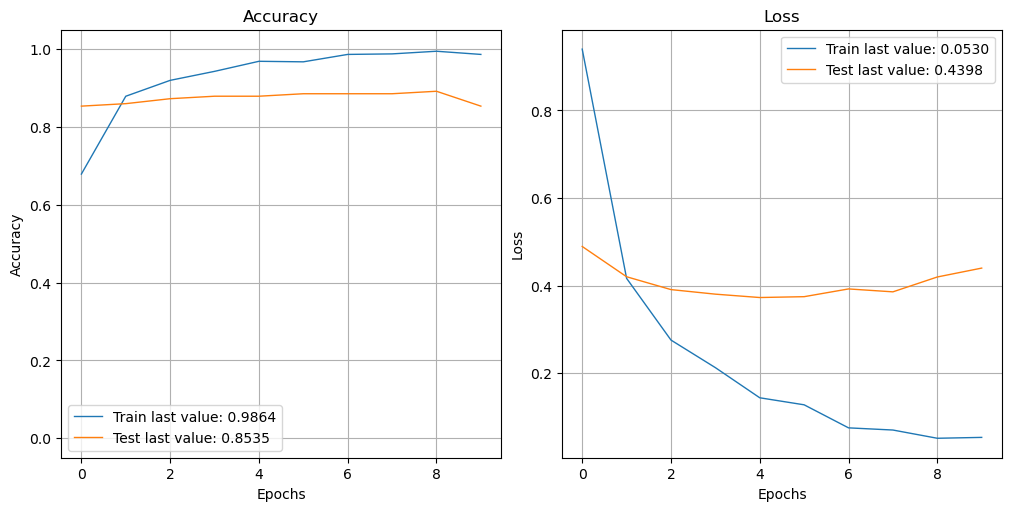

In [23]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

Ce graphique retrace l’évolution des performances du modèle au fil de l’entraînement, en présentant la perte (loss) et la précision (accuracy) sur les ensembles d’entraînement et de validation.

- La perte mesure l’erreur du modèle : plus elle est faible, meilleur est le modèle.

- La précision indique la proportion de prédictions correctes : plus elle est élevée, plus le modèle est performant.

L’analyse conjointe des courbes d’entraînement et de validation permet d’évaluer la capacité du modèle à apprendre efficacement tout en généralisant sur des données nouvelles, ce qui est essentiel pour éviter le surapprentissage.

Sur ce graphique, on observe que le modèle atteint une précision de 98,6 % sur l’entraînement et de 85,4 % sur le test, avec une perte respective de 0,053 et 0,44. Ces résultats traduisent un apprentissage efficace, mais révèlent également un léger surapprentissage : le modèle commence à mémoriser les données d’entraînement au détriment de sa capacité à généraliser.

Ce phénomène se manifeste lorsque la performance sur l’entraînement continue de s’améliorer alors que celle sur le test stagne ou diminue. Pour y remédier, la data augmentation s’impose comme une solution pertinente.

In [24]:
# y_val_oh : labels de validation au format one-hot
y_val_num = np.argmax(y_val_oh, axis=1)  # Vraies classes (entiers)
y_val_pred = np.argmax(model1.predict(X_val_np), axis=1)  # Prédictions du modèle
print("Vraies classes :", y_val_num)
print("Prédictions :", y_val_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 
Vraies classes : [3 2 5 4 2 4 1 5 4 0 0 5 3 5 1 3 4 5 1 6 1 1 0 3 3 4 4 5 4 0 3 2 3 5 1 3 0
 0 6 5 4 6 4 6 6 6 0 3 3 4 4 4 2 1 2 6 5 6 3 3 6 6 6 4 0 3 2 4 5 5 3 3 6 2
 6 3 3 0 2 3 5 4 2 2 5 5 0 3 3 0 0 0 2 0 1 1 2 0 2 0 5 5 2 6 1 1 6 1 6 1 0
 1 5 6 3 0 4 1 2 0 3 2 1 5 6 6 4 5 2 2 1 0 5 2 5 6 4 6 4 1 1 5 4 0 5 1 0 2
 1 0 6 2 2 4 1 4 1]
Prédictions : [5 2 5 4 2 4 1 5 4 4 0 5 3 5 1 3 4 5 2 6 3 1 0 3 3 4 4 5 4 0 3 2 3 5 1 3 4
 0 6 5 4 6 0 6 6 6 0 3 3 4 4 4 2 6 6 6 5 6 5 0 6 6 6 4 0 3 2 4 5 5 3 3 6 2
 6 3 3 4 3 3 5 4 2 2 5 5 6 3 5 3 0 0 2 2 3 1 2 0 2 0 5 5 2 6 1 1 6 3 6 1 0
 1 5 6 3 0 4 1 2 0 3 2 1 5 6 6 4 5 2 2 1 0 5 2 5 6 4 6 4 1 1 5 4 0 5 1 0 2
 1 3 6 2 2 4 1 4 1]


In [25]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :\n", conf_mat)

Matrice de confusion :
 [[16  0  1  2  3  0  1]
 [ 0 18  1  3  0  0  1]
 [ 0  0 20  1  0  0  1]
 [ 1  0  0 18  0  3  0]
 [ 1  0  0  0 21  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0 22]]


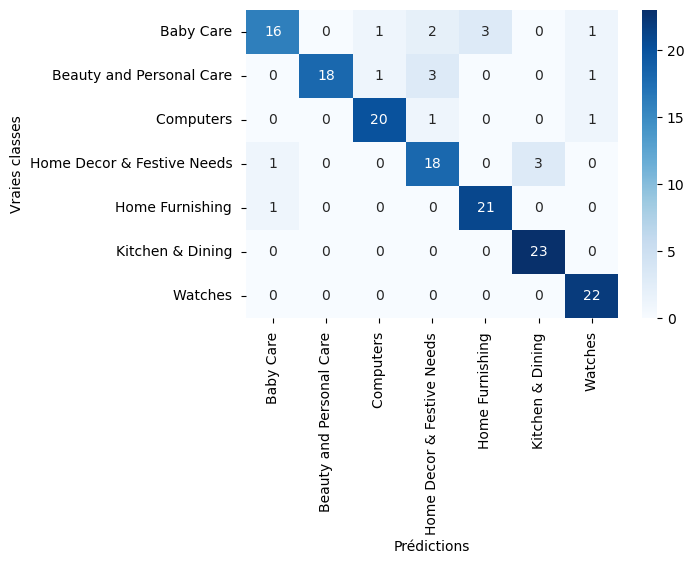

In [31]:
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=list_labels)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.show()

In [30]:
print(metrics.classification_report(y_val_num, y_val_pred, target_names=list_labels))

                             precision    recall  f1-score   support

                 Baby Care        0.89      0.70      0.78        23
  Beauty and Personal Care        1.00      0.78      0.88        23
                 Computers        0.91      0.91      0.91        22
Home Decor & Festive Needs        0.75      0.82      0.78        22
           Home Furnishing        0.88      0.95      0.91        22
          Kitchen & Dining        0.88      1.00      0.94        23
                   Watches        0.88      1.00      0.94        22

                   accuracy                           0.88       157
                  macro avg       0.88      0.88      0.88       157
               weighted avg       0.88      0.88      0.88       157



Le modèle atteint une accuracy de 88 % sur l’ensemble de validation.
- La précision (precision) mesure la proportion de prédictions correctes parmi toutes les prédictions faites pour chaque classe.

- Le rappel (recall) indique la proportion d’exemples correctement retrouvés parmi tous les exemples réels de chaque classe.

- Le F1-score combine précision et rappel pour donner une mesure globale de la performance sur chaque classe (plus il est proche de 1, mieux c’est).

Les scores de précision, rappel et F1-score sont élevés et globalement équilibrés entre les classes, ce qui montre une bonne capacité de généralisation. Quelques confusions subsistent, notamment pour “Baby Care” et “Home Decor & Festive Needs”, mais la plupart des classes sont bien reconnues, avec des scores supérieurs à 0.9 pour plusieurs d’entre elles.

La matrice de confusion montre que la majorité des erreurs concernent des classes proches, mais aucune classe n’est systématiquement mal classée.

# Amélioration du modèle par Data Augmentation
Afin de limiter le surapprentissage observé lors de l’entraînement initial, nous allons introduire une étape de data augmentation.
Cette technique consiste à générer automatiquement de nouvelles images à partir des images existantes (par exemple via des rotations, des zooms, des modifications de luminosité, etc.), ce qui permet d’enrichir le jeu de données et d’exposer le modèle à une plus grande diversité de situations.

L’objectif est d’améliorer la capacité de généralisation du modèle, de réduire l’écart de performance entre l’entraînement et la validation, et d’obtenir des résultats plus robustes sur des données inédites.
## Construction du modèle de classification avec EfficientNetB0 et data augmentation

Dans cette étape, nous enrichissons notre modèle de classification basé sur EfficientNetB0 en intégrant une couche de data augmentation directement au sein de l’architecture. Concrètement, nous ajoutons en entrée du modèle une séquence de transformations aléatoires (telles que des rotations, des zooms et des flips horizontaux) qui ne s’appliquent qu’aux images d’entraînement. Cette stratégie permet de générer automatiquement de nouvelles variantes à partir des images existantes, sans modifier les données de validation ou de test.

L’utilisation d’EfficientNetB0 comme backbone permet de bénéficier d’un réseau convolutif moderne et efficace, pré-entraîné sur ImageNet, qui extrait des caractéristiques visuelles pertinentes à partir des images. L’ajout de la data augmentation améliore la robustesse et la capacité de généralisation du modèle, tout en limitant le risque de surapprentissage sur le jeu d’entraînement.

Nous avons choisi d’intégrer la data augmentation directement dans le modèle, plutôt que d’utiliser ImageDataGenerator, car nos images étaient déjà prétraitées et prêtes à l’emploi sous forme de tableaux NumPy. Cette approche est plus simple et parfaitement adaptée à notre pipeline.

En résumé, cette étape combine la puissance du transfer learning avec des techniques d’augmentation de données pour optimiser les performances du modèle sur des images inédites.

In [32]:
# Définition de la séquence de data augmentation à appliquer uniquement sur les images d'entraînement
data_augmentation = Sequential([
    # Applique un retournement horizontal aléatoire à chaque image (simule une vue miroir)
    tf.keras.layers.RandomFlip("horizontal"),
    
    # Applique une rotation aléatoire jusqu'à ±10% de l'image (0.1 = 10% de 360°)
    tf.keras.layers.RandomRotation(0.1),
    
    # Applique un zoom aléatoire jusqu'à ±20% sur l'image
    tf.keras.layers.RandomZoom(0.2)
], name="data_augmentation")


def create_efficientnet_model_with_aug(num_classes):
    """
    Crée un modèle de classification d’images basé sur EfficientNetB0, intégrant une couche de data augmentation.

    Ce modèle applique d’abord des transformations aléatoires (data augmentation) aux images d’entrée,
    puis utilise EfficientNetB0 pré-entraîné (sans sa tête de classification) pour extraire des caractéristiques visuelles.
    Des couches denses personnalisées sont ajoutées pour adapter le modèle à une tâche de classification multi-classes.

    Paramètres
    ----------
    num_classes : int
        Nombre de classes à prédire (taille de la couche de sortie).

    Retourne
    -------
    model : keras.Model
        Modèle Keras compilé, prêt à être entraîné.
    """
    # Définition de l’entrée du modèle (images de taille 224x224x3)
    inputs = Input(shape=(224, 224, 3))
    
    # Application de la data augmentation uniquement pendant l'entraînement
    x = data_augmentation(inputs)
    
    # Chargement du backbone EfficientNetB0 pré-entraîné sur ImageNet, sans la couche de classification finale
    # On connecte le backbone à la sortie de la data augmentation
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    
    # Extraction des features du backbone
    x = base_model.output
    
    # Réduction de la dimension des features avec un pooling global
    x = GlobalAveragePooling2D()(x)
    
    # Couche dense pour apprendre des combinaisons non linéaires des features extraits
    x = Dense(256, activation='relu')(x)
    
    # Dropout pour limiter le surapprentissage
    x = Dropout(0.5)(x)
    
    # Couche de sortie adaptée au nombre de classes, avec activation softmax pour la classification multi-classes
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Définition du modèle complet (entrée = image, sortie = prédiction de classe)
    model = Model(inputs, outputs)
    
    # Compilation du modèle avec une loss adaptée à la classification multi-classes
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    # Affichage du résumé du modèle pour vérification
    model.summary()
    
    return model

num_classes = y_train_oh.shape[1]
model2 = create_efficientnet_model_with_aug(num_classes)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ data_augmentation             │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
│ (Sequential)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ data_augmentation[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 224, 224, 3)       │               7 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_3 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Mise en place des callbacks

In [33]:
model2_save_path = "./efficientnet2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, early_stop]

## Entraînement du modèle avec data augmentation

In [34]:
history2 = model2.fit(
    X_train_np, y_train_oh,
    epochs=50,
    batch_size=64,  
    validation_data=(X_val_np, y_val_oh),
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4445 - loss: 1.4872
Epoch 1: val_loss improved from inf to 0.88678, saving model to ./efficientnet2_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 203s 10s/step - accuracy: 0.4547 - loss: 1.4652 - val_accuracy: 0.7452 - val_loss: 0.8868
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8442 - loss: 0.5024
Epoch 2: val_loss improved from 0.88678 to 0.78575, saving model to ./efficientnet2_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 97s 8s/step - accuracy: 0.8452 - loss: 0.4976 - val_accuracy: 0.7898 - val_loss: 0.7857
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9355 - loss: 0.2689
Epoch 3: val_loss did not improve from 0.78575
12/12 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - accuracy: 0.9360 - loss: 0.2655 - val_accuracy: 0.7898 - val_loss: 1.0403
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9700 - loss: 0.1352
Epoch 4: val_loss did not improve from 0.78575
12/12 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step - accuracy: 0.9700 - loss: 0.1339 - val_accuracy: 0.8089 - val_loss: 1.1338
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9671 - loss: 0.0958
Epoch 5: val_loss did not improve from 0.78575
12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.9668 - loss: 0.0975 - val_accuracy: 0.8089 - val_loss: 1.0109
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9715 - loss: 0.1084
Epoch 6: val_loss did not improve from 0.78575
12/12 ━━━━━━━━━━━━━━

## Evaluation du modèle

In [44]:
# Évaluation avec les poids du dernier epoch (avant de recharger les meilleurs poids)
loss, accuracy = model2.evaluate(X_train_np, y_train_oh, verbose=True)
print("Précision sur l'entraînement (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (dernier epoch) : {:.4f}".format(loss))
print()

loss, accuracy = model2.evaluate(X_val_np, y_val_oh, verbose=True)
print("Précision sur la validation (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur la validation (dernier epoch) : {:.4f}".format(loss))
print()

# Chargement des meilleurs poids sauvegardés par ModelCheckpoint
model2.load_weights(model2_save_path)

# Évaluation sur l'ensemble d'entraînement avec les meilleurs poids
loss, accuracy = model2.evaluate(X_train_np, y_train_oh, verbose=False)
print("Précision sur l'entraînement (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de validation avec les meilleurs poids
loss, accuracy = model2.evaluate(X_val_np, y_val_oh, verbose=False)
print("Précision sur la validation (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur la validation (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de test avec les meilleurs poids
loss, accuracy = model2.evaluate(X_test_np, y_test_oh, verbose=False)
print("Précision sur le test (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur le test (meilleurs poids) : {:.4f}".format(loss))

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step - accuracy: 0.8780 - loss: 0.4344
Précision sur l'entraînement (dernier epoch) : 0.8816
Loss sur l'entraînement (dernier epoch) : 0.4013

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step - accuracy: 0.7663 - loss: 0.9995
Précision sur la validation (dernier epoch) : 0.7898
Loss sur la validation (dernier epoch) : 0.7857

Précision sur l'entraînement (meilleurs poids) : 0.8816
Loss sur l'entraînement (meilleurs poids) : 0.4013

Précision sur la validation (meilleurs poids) : 0.7898
Loss sur la validation (meilleurs poids) : 0.7857

Précision sur le test (meilleurs poids) : 0.7975
Loss sur le test (meilleurs poids) : 0.6805


|                         | Entraînement (meilleurs poids) | Validation (meilleurs poids) | Test (meilleurs poids) |
|:------------------------|:-------------------------------:|:----------------------------:|:-----------------------:|
| **Précision (MLP minimal)**   | 0.4721                         | 0.3567                       | 0.3734                  |
| **Précision (CNN)**   | 0.6571                         | 0.4777                       | 0.5063                  |
| **Précision (EfficientNetB0 sans DA)** | 0.9891                         | 0.8790                       | 0.8797                  |
| **Précision (EfficientNetB0 avec DA)**  | 0.8816                         | 0.7898                       | 0.7975                  |


L'ajout de data augmentation entraîne une baisse attendue de la précision sur l'entraînement, la validation et le test. Cette baisse est due à la plus grande variabilité introduite dans les données, ce qui rend l'apprentissage plus difficile mais améliore la robustesse du modèle. Malgré une perte de précision, le modèle entraîné avec data augmentation est potentiellement mieux généralisable à de nouvelles données non vues.<br>
La data augmentation a permis de réduire le surapprentissage en rapprochant les performances entre l'entraînement et le test, au prix d'une légère baisse des scores globaux.

On observe qu’il reste un léger surapprentissage dans les deux cas, car la précision sur l’entraînement reste supérieure à celle sur la validation et le test. Cependant, l’ajout de la data augmentation réduit cet écart : le modèle devient moins dépendant des données d’entraînement et plus robuste face à des données nouvelles. Cela se traduit par des performances plus homogènes entre les différents ensembles, signe d’une meilleure généralisation.

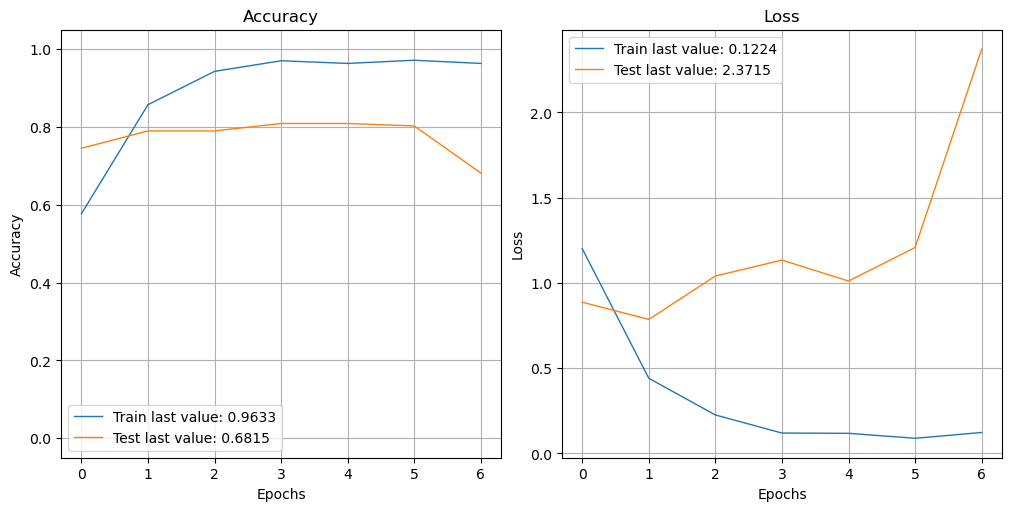

In [37]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

Les courbes d’apprentissage montrent un début de surapprentissage à partir d’un certain nombre d’epochs. Cependant, grâce à l’utilisation de l’early stopping et du ModelCheckpoint, la version finale du modèle correspond à l’état où il généralise le mieux, ce qui permet d’éviter un surapprentissage excessif et d’obtenir des performances robustes sur les données de validation et de test.

In [38]:
# y_val_oh : labels de validation au format one-hot
y_val_num = np.argmax(y_val_oh, axis=1)  # Vraies classes (entiers)
y_val_pred = np.argmax(model2.predict(X_val_np), axis=1)  # Prédictions du modèle
print("Vraies classes :", y_val_num)
print("Prédictions :", y_val_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step 
Vraies classes : [3 2 5 4 2 4 1 5 4 0 0 5 3 5 1 3 4 5 1 6 1 1 0 3 3 4 4 5 4 0 3 2 3 5 1 3 0
 0 6 5 4 6 4 6 6 6 0 3 3 4 4 4 2 1 2 6 5 6 3 3 6 6 6 4 0 3 2 4 5 5 3 3 6 2
 6 3 3 0 2 3 5 4 2 2 5 5 0 3 3 0 0 0 2 0 1 1 2 0 2 0 5 5 2 6 1 1 6 1 6 1 0
 1 5 6 3 0 4 1 2 0 3 2 1 5 6 6 4 5 2 2 1 0 5 2 5 6 4 6 4 1 1 5 4 0 5 1 0 2
 1 0 6 2 2 4 1 4 1]
Prédictions : [5 2 5 4 2 4 1 5 4 0 0 5 3 5 1 3 4 5 2 6 6 1 2 3 5 1 4 5 4 2 3 2 6 5 1 3 4
 0 6 5 4 6 0 6 6 6 0 1 4 4 4 4 2 6 6 6 5 6 5 0 6 6 6 4 0 1 2 4 5 1 3 3 6 2
 6 3 3 4 6 0 5 4 2 2 5 5 6 3 5 1 0 0 2 5 6 1 2 2 2 0 5 5 2 6 1 1 6 3 6 1 2
 1 5 6 5 0 4 1 2 0 0 2 1 5 6 6 4 5 2 5 1 0 5 2 5 6 4 6 4 1 1 5 4 0 5 1 0 2
 1 4 6 2 2 4 1 4 1]


In [39]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :\n", conf_mat)

Matrice de confusion :
 [[13  1  4  0  3  1  1]
 [ 0 18  1  1  0  0  3]
 [ 0  0 19  0  0  1  2]
 [ 3  2  0 10  1  5  1]
 [ 1  1  0  0 20  0  0]
 [ 0  1  0  0  0 22  0]
 [ 0  0  0  0  0  0 22]]


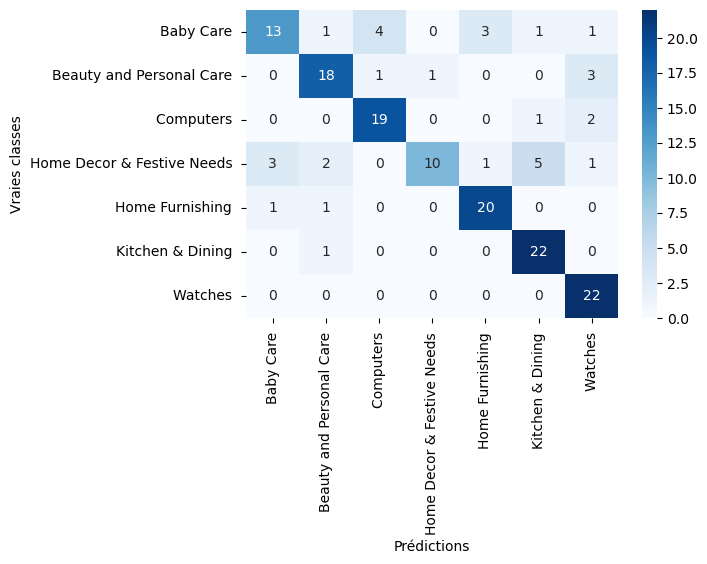

In [41]:
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=list_labels)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.show()

La data augmentation rend la tâche plus difficile (normal car les données sont déformées).

Le modèle reste robuste sur certaines classes, mais a plus de mal sur d'autres (surtout les classes proches ou visuellement similaires).

In [40]:
print(metrics.classification_report(y_val_num, y_val_pred, target_names=list_labels))

                             precision    recall  f1-score   support

                 Baby Care        0.76      0.57      0.65        23
  Beauty and Personal Care        0.78      0.78      0.78        23
                 Computers        0.79      0.86      0.83        22
Home Decor & Festive Needs        0.91      0.45      0.61        22
           Home Furnishing        0.83      0.91      0.87        22
          Kitchen & Dining        0.76      0.96      0.85        23
                   Watches        0.76      1.00      0.86        22

                   accuracy                           0.79       157
                  macro avg       0.80      0.79      0.78       157
               weighted avg       0.80      0.79      0.78       157



- Baisse attendue de toutes les métriques : précision, rappel et F1 tombent autour de 79–80 %.

- Certaines classes chutent beaucoup (ex. "Home Decor & Festive Needs" avec un rappel de 0.45).

- D'autres restent solides, comme "Kitchen & Dining" et "Watches" (presque pas d'erreurs sur le rappel).

- Cela montre que le modèle devient plus robuste sur certaines classes, mais plus fragile sur d'autres.

# Amélioration du modèle par Data Augmentation et baisse du drop out

Dans cette section, nous nous concentrons sur l'optimisation du modèle en ajustant le taux de Dropout. Après avoir observé une légère amélioration du modèle grâce à la Data Augmentation dans la section précédente, nous avons cherché à réduire le surapprentissage restant en modifiant le taux de Dropout. En abaissant ce taux de 0.5 à 0.3, l'objectif était de trouver un équilibre entre régularisation et capacité d'apprentissage, permettant au modèle de mieux généraliser tout en conservant sa capacité à apprendre les caractéristiques pertinentes des données d'entraînement.

Cette approche vise à réduire l'écart de performance entre l'entraînement et les ensembles de validation/test, en permettant au modèle de mieux exploiter les informations apprises, tout en évitant une sur-régularisation qui pourrait nuire à sa capacité à bien se comporter sur des données nouvelles.

## Construction du modèle de classification avec EfficientNetB0 et data augmentation

In [53]:
# Définition de la séquence de data augmentation à appliquer uniquement sur les images d'entraînement
data_augmentation = Sequential([
    # Applique un retournement horizontal aléatoire à chaque image (simule une vue miroir)
    tf.keras.layers.RandomFlip("horizontal"),
    
    # Applique une rotation aléatoire jusqu'à ±10% de l'image (0.1 = 10% de 360°)
    tf.keras.layers.RandomRotation(0.1),
    
    # Applique un zoom aléatoire jusqu'à ±20% sur l'image
    tf.keras.layers.RandomZoom(0.2)
], name="data_augmentation")


def create_efficientnet_model_with_aug(num_classes):
    """
    Crée un modèle de classification d’images basé sur EfficientNetB0, intégrant une couche de data augmentation.

    Ce modèle applique d’abord des transformations aléatoires (data augmentation) aux images d’entrée,
    puis utilise EfficientNetB0 pré-entraîné (sans sa tête de classification) pour extraire des caractéristiques visuelles.
    Des couches denses personnalisées sont ajoutées pour adapter le modèle à une tâche de classification multi-classes.

    Paramètres
    ----------
    num_classes : int
        Nombre de classes à prédire (taille de la couche de sortie).

    Retourne
    -------
    model : keras.Model
        Modèle Keras compilé, prêt à être entraîné.
    """
    # Définition de l’entrée du modèle (images de taille 224x224x3)
    inputs = Input(shape=(224, 224, 3))
    
    # Application de la data augmentation uniquement pendant l'entraînement
    x = data_augmentation(inputs)
    
    # Chargement du backbone EfficientNetB0 pré-entraîné sur ImageNet, sans la couche de classification finale
    # On connecte le backbone à la sortie de la data augmentation
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    
    # Extraction des features du backbone
    x = base_model.output
    
    # Réduction de la dimension des features avec un pooling global
    x = GlobalAveragePooling2D()(x)
    
    # Couche dense pour apprendre des combinaisons non linéaires des features extraits
    x = Dense(256, activation='relu')(x)
    
    # Dropout pour limiter le surapprentissage
    x = Dropout(0.3)(x)# changement de ce paramètre (on passe de 0.5 à 0.3)
    
    # Couche de sortie adaptée au nombre de classes, avec activation softmax pour la classification multi-classes
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Définition du modèle complet (entrée = image, sortie = prédiction de classe)
    model = Model(inputs, outputs)
    
    # Compilation du modèle avec une loss adaptée à la classification multi-classes
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    # Affichage du résumé du modèle pour vérification
    model.summary()
    
    return model

num_classes = y_train_oh.shape[1]
model3 = create_efficientnet_model_with_aug(num_classes)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ data_augmentation             │ (None, 224, 224, 3)       │               0 │ input_layer_5[0][0]        │
│ (Sequential)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_6 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ data_augmentation[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_3               │ (None, 224, 224, 3)       │               7 │ rescaling_6[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_7 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_7[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Mise en place des callbacks

In [54]:
model3_save_path = "./efficientnet3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, early_stop]

## Entraînement du modèle avec data augmentation et drop out à 0.3

In [55]:
history3 = model3.fit(
    X_train_np, y_train_oh,
    epochs=50,
    batch_size=64,  
    validation_data=(X_val_np, y_val_oh),
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4773 - loss: 1.3777
Epoch 1: val_loss improved from inf to 0.91595, saving model to ./efficientnet3_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 164s 9s/step - accuracy: 0.4865 - loss: 1.3584 - val_accuracy: 0.7134 - val_loss: 0.9159
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8544 - loss: 0.4986
Epoch 2: val_loss improved from 0.91595 to 0.76565, saving model to ./efficientnet3_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step - accuracy: 0.8564 - loss: 0.4924 - val_accuracy: 0.8153 - val_loss: 0.7657
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9131 - loss: 0.2367
Epoch 3: val_loss did not improve from 0.76565
12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.9151 - loss: 0.2328 - val_accuracy: 0.7707 - val_loss: 0.9798
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9744 - loss: 0.1022
Epoch 4: val_loss did not improve from 0.76565
12/12 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.9748 - loss: 0.1008 - val_accuracy: 0.7389 - val_loss: 0.9977
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9709 - loss: 0.0770
Epoch 5: val_loss did not improve from 0.76565
12/12 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.9709 - loss: 0.0783 - val_accuracy: 0.7643 - val_loss: 1.1753
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9890 - loss: 0.0550
Epoch 6: val_loss did not improve from 0.76565
12/12 ━━━━━━━━━━━━━━

## Evaluation du modèle

In [56]:
# Évaluation avec les poids du dernier epoch (avant de recharger les meilleurs poids)
loss, accuracy = model3.evaluate(X_train_np, y_train_oh, verbose=True)
print("Précision sur l'entraînement (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (dernier epoch) : {:.4f}".format(loss))
print()

loss, accuracy = model3.evaluate(X_val_np, y_val_oh, verbose=True)
print("Précision sur la validation (dernier epoch) : {:.4f}".format(accuracy))
print("Loss sur la validation (dernier epoch) : {:.4f}".format(loss))
print()

# Chargement des meilleurs poids sauvegardés par ModelCheckpoint
model3.load_weights(model3_save_path)

# Évaluation sur l'ensemble d'entraînement avec les meilleurs poids
loss, accuracy = model3.evaluate(X_train_np, y_train_oh, verbose=False)
print("Précision sur l'entraînement (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur l'entraînement (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de validation avec les meilleurs poids
loss, accuracy = model3.evaluate(X_val_np, y_val_oh, verbose=False)
print("Précision sur la validation (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur la validation (meilleurs poids) : {:.4f}".format(loss))
print()

# Évaluation sur l'ensemble de test avec les meilleurs poids
loss, accuracy = model3.evaluate(X_test_np, y_test_oh, verbose=False)
print("Précision sur le test (meilleurs poids) : {:.4f}".format(accuracy))
print("Loss sur le test (meilleurs poids) : {:.4f}".format(loss))

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 660ms/step - accuracy: 0.9564 - loss: 0.1462
Précision sur l'entraînement (dernier epoch) : 0.9592
Loss sur l'entraînement (dernier epoch) : 0.1569

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - accuracy: 0.7436 - loss: 2.3253
Précision sur la validation (dernier epoch) : 0.7516
Loss sur la validation (dernier epoch) : 1.9093

Précision sur l'entraînement (meilleurs poids) : 0.8898
Loss sur l'entraînement (meilleurs poids) : 0.3195

Précision sur la validation (meilleurs poids) : 0.8153
Loss sur la validation (meilleurs poids) : 0.7657

Précision sur le test (meilleurs poids) : 0.8101
Loss sur le test (meilleurs poids) : 0.5564


|                         | Entraînement (meilleurs poids) | Validation (meilleurs poids) | Test (meilleurs poids) |
|:------------------------|:-------------------------------:|:----------------------------:|:-----------------------:|
| **Précision (MLP minimal)**   | 0.4721                         | 0.3567                       | 0.3734                  |
| **Précision (CNN)**   | 0.6571                         | 0.4777                       | 0.5063                  |
| **Précision (EfficientNetB0 sans DA)** | 0.9891                         | 0.8790                       | 0.8797                  |
| **Précision (EfficientNetB0 avec DA)**  | 0.8816                         | 0.7898                       | 0.7975                  |
| **Précision (EfficientNetB0 avec DA + Dropout 0.3)**  | 0.8898                         | 0.8153                       | 0.8101                  |


L'ajustement du Dropout à 0.3, en plus de la Data Augmentation, a amélioré les performances et la généralisation du modèle. On observe :

- Entraînement : légère amélioration de la précision (0.8898 contre 0.8816) et réduction de la loss (0.3195 contre 0.4013).

- Validation : amélioration de la précision (0.8153 contre 0.7898) et réduction de la loss (0.7657 contre 0.7857).

- Test : augmentation de la précision (0.8101 contre 0.7975) et réduction de la loss (0.5564 contre 0.6805).


La DA réduit le surapprentissage mais peut limiter la capacité d’apprentissage (précision train plus basse).<br>
Le dropout compense partiellement cela en forçant le modèle à apprendre des motifs plus généralisables.

Ces résultats montrent que l'ajout du Dropout aide à réduire le surapprentissage et améliore la généralisation, ce qui est visible sur les ensembles de validation et test.

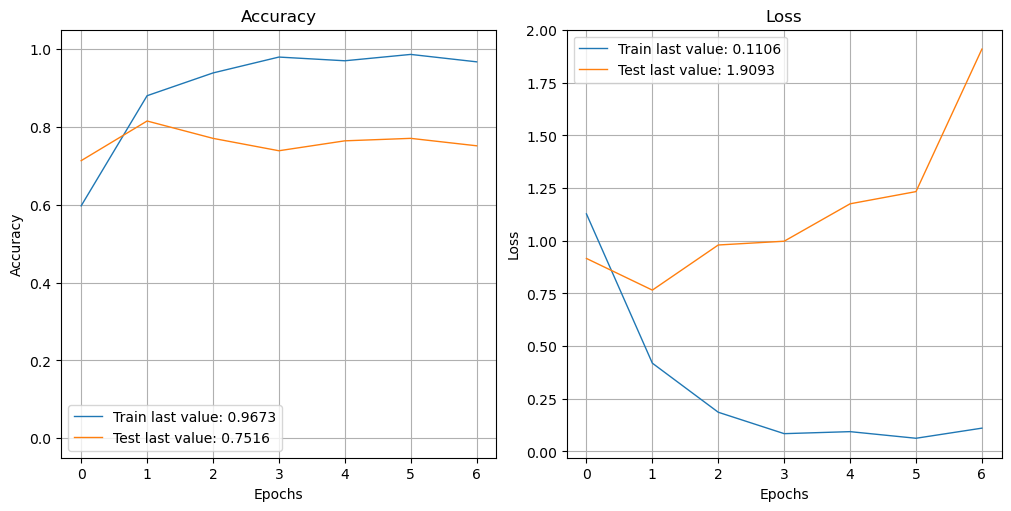

In [57]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [58]:
# y_val_oh : labels de validation au format one-hot
y_val_num = np.argmax(y_val_oh, axis=1)  # Vraies classes (entiers)
y_val_pred = np.argmax(model3.predict(X_val_np), axis=1)  # Prédictions du modèle
print("Vraies classes :", y_val_num)
print("Prédictions :", y_val_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 
Vraies classes : [3 2 5 4 2 4 1 5 4 0 0 5 3 5 1 3 4 5 1 6 1 1 0 3 3 4 4 5 4 0 3 2 3 5 1 3 0
 0 6 5 4 6 4 6 6 6 0 3 3 4 4 4 2 1 2 6 5 6 3 3 6 6 6 4 0 3 2 4 5 5 3 3 6 2
 6 3 3 0 2 3 5 4 2 2 5 5 0 3 3 0 0 0 2 0 1 1 2 0 2 0 5 5 2 6 1 1 6 1 6 1 0
 1 5 6 3 0 4 1 2 0 3 2 1 5 6 6 4 5 2 2 1 0 5 2 5 6 4 6 4 1 1 5 4 0 5 1 0 2
 1 0 6 2 2 4 1 4 1]
Prédictions : [1 2 5 4 2 4 1 5 0 0 0 5 3 5 1 3 4 5 2 6 5 1 2 3 5 1 4 5 4 0 1 0 6 5 1 3 4
 0 6 5 1 6 0 6 6 6 0 1 3 4 4 0 2 6 6 6 5 6 5 0 6 6 6 4 0 3 2 4 5 5 3 3 6 2
 6 3 3 4 2 3 5 4 2 2 5 5 5 3 5 1 0 0 2 2 6 1 2 0 5 0 5 5 2 6 1 1 6 6 6 1 0
 1 5 6 3 0 4 1 2 0 3 2 1 5 6 6 4 5 2 0 1 0 5 2 5 6 4 6 0 1 1 5 4 0 5 1 0 2
 1 0 6 2 2 4 1 4 1]


In [59]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :\n", conf_mat)

Matrice de confusion :
 [[17  1  2  0  2  1  0]
 [ 0 18  1  0  0  1  3]
 [ 2  0 18  0  0  1  1]
 [ 1  3  0 14  0  3  1]
 [ 4  2  0  0 16  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0 22]]


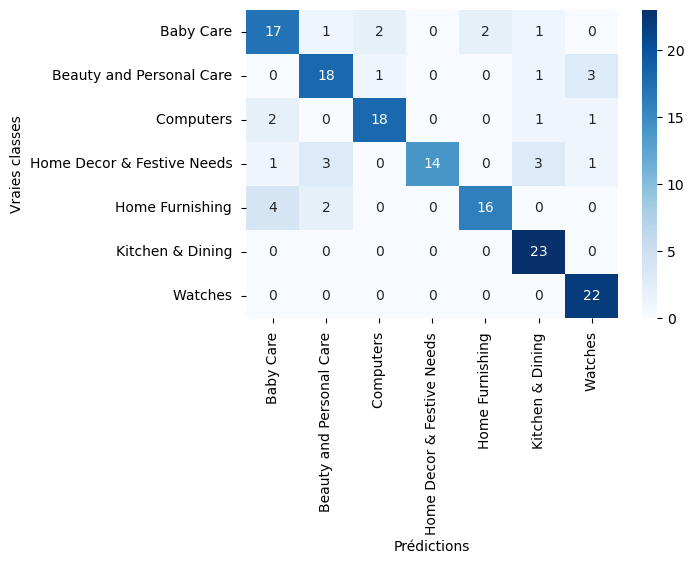

In [60]:
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=list_labels)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.show()

In [61]:
print(metrics.classification_report(y_val_num, y_val_pred, target_names=list_labels))

                             precision    recall  f1-score   support

                 Baby Care        0.71      0.74      0.72        23
  Beauty and Personal Care        0.75      0.78      0.77        23
                 Computers        0.86      0.82      0.84        22
Home Decor & Festive Needs        1.00      0.64      0.78        22
           Home Furnishing        0.89      0.73      0.80        22
          Kitchen & Dining        0.79      1.00      0.88        23
                   Watches        0.81      1.00      0.90        22

                   accuracy                           0.82       157
                  macro avg       0.83      0.81      0.81       157
               weighted avg       0.83      0.82      0.81       157



L'ajout de Dropout à 0.3 améliore les performances globales du modèle. La précision totale augmente de 0.79 à 0.82. On remarque des améliorations dans certaines classes comme Computers et Kitchen & Dining, avec des augmentations de précision et de recall. Le modèle devient plus équilibré, avec une meilleure généralisation. Le macro average et le weighted average montrent des gains notables en précision, recall et f1-score, ce qui indique une meilleure gestion des erreurs et une plus grande robustesse.

# Évaluation finale sur le jeu de test

Après avoir testé plusieurs architectures et stratégies d'entraînement, nous avons choisi le modèle offrant le meilleur compromis entre performance sur le jeu de validation et capacité à généraliser. Dans cette phase finale, nous évaluons ce modèle "final" sur le jeu de test, totalement indépendant, afin d'obtenir une estimation objective de ses performances réelles dans un contexte hors échantillon.

Les résultats du modèle final, incluant les métriques globales de précision et de perte, sont présentés ci-dessous. Ces résultats sont complétés par une analyse détaillée de la matrice de confusion et du rapport de classification, afin de valider la robustesse du modèle et d'identifier des pistes d'amélioration potentielles. L'évaluation sur le jeu de test permet de confirmer la stabilité du modèle et de s'assurer qu'il est capable de maintenir ses performances dans des situations réelles.

Cette analyse approfondie nous aide à mieux comprendre les forces et les faiblesses du modèle final, et ouvre la voie à des améliorations futures, telles que l'optimisation des hyperparamètres, le traitement des classes déséquilibrées, ou l'exploration d'autres architectures plus complexes.

In [76]:
# y_test_oh : labels de validation au format one-hot
y_test_num = np.argmax(y_test_oh, axis=1)  # Vraies classes (entiers)
y_test_pred = np.argmax(model3.predict(X_test_np), axis=1)  # Prédictions du modèle
print("Vraies classes :", y_test_num)
print("Prédictions :", y_test_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 670ms/step
Vraies classes : [6 4 2 5 4 6 2 4 6 2 1 4 0 2 0 4 5 5 5 5 0 6 6 5 5 1 2 0 0 6 1 4 5 3 2 2 6
 1 3 3 5 1 3 4 4 3 2 0 0 5 4 6 5 0 1 0 3 5 1 2 2 1 2 5 3 2 3 1 3 6 6 2 1 3
 0 3 5 2 4 6 0 2 4 6 6 0 1 4 0 2 5 1 2 1 4 6 3 4 5 2 4 2 6 3 6 0 4 0 3 1 5
 3 4 5 2 3 0 4 5 6 5 6 1 4 0 3 3 3 1 2 4 6 1 1 1 3 2 2 0 4 1 5 6 3 5 0 3 1
 0 0 6 0 4 6 6 1 4 3]
Prédictions : [6 4 2 5 4 6 2 0 6 2 2 1 4 2 0 4 5 5 5 5 0 6 6 5 5 1 2 0 0 6 1 0 5 5 2 2 6
 1 3 3 5 1 3 4 4 3 5 4 2 5 4 6 5 0 4 0 3 5 1 2 2 1 5 5 0 2 3 1 3 6 6 2 1 4
 4 2 5 2 4 6 0 2 4 6 6 0 1 4 0 2 5 1 2 1 4 6 3 4 5 2 0 5 6 3 6 0 4 0 5 1 5
 0 4 5 2 3 0 0 5 6 2 6 1 4 0 5 3 3 1 2 2 6 1 1 1 3 2 2 0 4 5 5 6 2 5 0 5 6
 2 0 6 0 0 6 6 1 0 3]


In [77]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred)
print("Matrice de confusion :\n", conf_mat)

Matrice de confusion :
 [[17  0  2  0  3  0  0]
 [ 0 18  1  0  1  1  1]
 [ 0  0 20  0  0  3  0]
 [ 2  0  2 14  1  4  0]
 [ 6  1  1  0 15  0  0]
 [ 0  0  1  0  0 21  0]
 [ 0  0  0  0  0  0 23]]


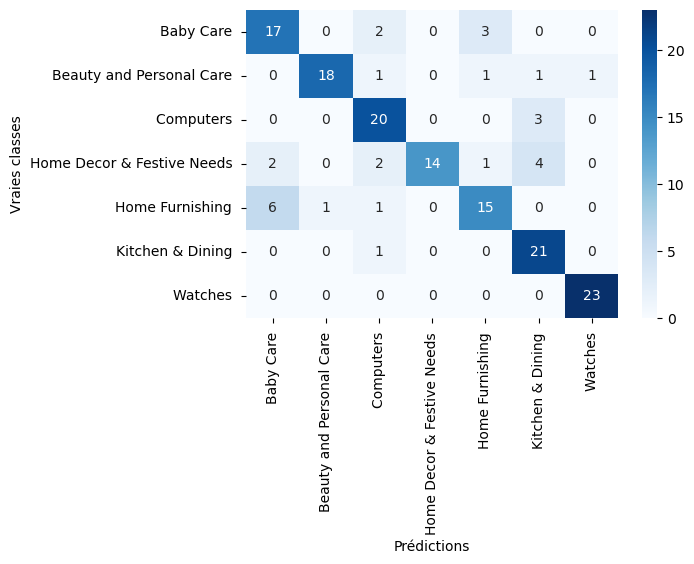

In [78]:
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=list_labels)
plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.show()

In [79]:
print(metrics.classification_report(y_test_num, y_test_pred, target_names=list_labels))

                             precision    recall  f1-score   support

                 Baby Care        0.68      0.77      0.72        22
  Beauty and Personal Care        0.95      0.82      0.88        22
                 Computers        0.74      0.87      0.80        23
Home Decor & Festive Needs        1.00      0.61      0.76        23
           Home Furnishing        0.75      0.65      0.70        23
          Kitchen & Dining        0.72      0.95      0.82        22
                   Watches        0.96      1.00      0.98        23

                   accuracy                           0.81       158
                  macro avg       0.83      0.81      0.81       158
               weighted avg       0.83      0.81      0.81       158



**Analyse des performances finales sur le jeu de test**<br>
Le modèle EfficientNetB0 optimisé (avec Data Augmentation et Dropout) atteint une précision globale de 81 % sur le jeu de test, ce qui confirme sa bonne capacité de généralisation observée lors de la validation.

**Forces du modèle**<br>
- Les classes “Watches” (f1-score : 0.98, rappel : 1.00) et “Beauty and Personal Care” (f1-score : 0.88) sont très bien reconnues. Cela signifie que le modèle distingue très bien ces catégories, avec peu ou pas d’erreurs.

- “Kitchen & Dining” (f1-score : 0.82, rappel : 0.95) et “Computers” (f1-score : 0.80, rappel : 0.87) affichent également d’excellents résultats, montrant une capacité à bien séparer ces classes des autres.

**Points à surveiller**<br>
- “Home Decor & Festive Needs” présente un rappel plus faible (0.61), bien que la précision soit parfaite (1.00). Cela indique que le modèle ne prédit cette classe que lorsqu’il est très sûr, mais omet certains exemples qui devraient être classés dans cette catégorie (faux négatifs).

- “Home Furnishing” et “Baby Care” sont un peu moins bien reconnues (f1-score autour de 0.70-0.72). La matrice de confusion montre que le modèle confond parfois “Home Furnishing” avec “Baby Care” et inversement, ce qui suggère une similarité visuelle ou un recouvrement dans les caractéristiques extraites.

**Bilan global**
- Aucune classe n’est complètement oubliée : toutes atteignent un f1-score supérieur à 0.70, ce qui est assez satisfaisant pour un problème de classification multi-classes.

- La matrice de confusion montre que la plupart des erreurs sont des confusions entre classes proches, mais il n’y a pas de classe systématiquement ignorée ou mal prédite.

- Les moyennes (macro et pondérée) sont très proches de l’accuracy, ce qui indique un bon équilibre des performances entre les différentes classes.

**Conclusion**
Le modèle final est robuste et bien généralisant. Il parvient à distinguer efficacement la majorité des catégories, avec des performances particulièrement élevées sur certaines classes. Les quelques confusions restantes pourraient être réduites par un enrichissement du jeu de données ou une exploration de modèles encore plus spécialisés, mais le niveau atteint est déjà très satisfaisant pour une application concrète.

# Conclusion du projet

Nos analyses ont montré (notebook précédent) que certaines catégories sont mieux distinguées par le texte (notamment home finishing), d’autres par l’image. Pour améliorer la classification on pourrait:

- Exploiter la complémentarité texte + image en construisant un modèle multimodal combinant les deux sources d’information.

- Traiter spécifiquement les catégories ambiguës (ex. Baby Care vs Beauty and Personal Care) avec des sous-modèles ou des règles adaptées.

- Enrichir les données pour les classes difficiles, en augmentant la diversité des images et en améliorant la qualité des descriptions textuelles.

- Utiliser des modèles avancés pour l’image (EfficientNet fine-tuné, Vision Transformers).

- Fusionner intelligemment les prédictions des modèles texte et image pour tirer parti de leurs forces respectives.

Cette approche multimodale et ciblée permettrait de mieux gérer les ambiguïtés et d’améliorer la précision globale du système.